# Setup and Imports

In [ ]:
!pip install rasterio albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.3 MB/s eta 0:00:00:00:0100:01


In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6.3 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: n

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import albumentations as A

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
from google.colab import drive



---


# Reading the dataset

## Mount Google Drive

In [ ]:
# drive.mount('/content/drive')

## Extract Zip File

In [ ]:
## Colab

# zip_path = '/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 3: Satellite Images Flooding Segmentation/satalite data-20250918T154859Z-1-001.zip'
# extract_to = '/content/data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

In [ ]:
## Kaggle

kaggle_input_data = "/kaggle/input/sat-images-water-bodies/satalite data-20250918T154859Z-1-001/satalite data/data"

## Define Directory Paths

In [ ]:
## Drive

# images_dir = os.path.join(extract_to, 'satalite data/data/images')
# labels_dir = os.path.join(extract_to, 'satalite data/data/labels')

In [ ]:
## Kaggle
images_dir = os.path.join(kaggle_input_data, 'images')
labels_dir = os.path.join(kaggle_input_data, 'labels')

## **Function to Get Matched Image-Mask Pairs

In [ ]:
def get_matched_pairs(images_dir, labels_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
    pairs = []
    for img_file in image_files:
        stem = os.path.splitext(img_file)[0]
        mask_path = os.path.join(labels_dir, stem + '.png')
        if os.path.exists(mask_path):
            pairs.append((os.path.join(images_dir, img_file), mask_path))
    return pairs

In [ ]:
pairs = get_matched_pairs(images_dir, labels_dir)
print(f"Found {len(pairs)} matched pairs.")

Found 306 matched pairs.


---

# Dataset Preprocessing

## Split into Train and Test Pairs

In [ ]:
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

## Function to Load Multispectral Image

In [ ]:
def load_image(path):
    with rasterio.open(path) as src:
        img = src.read()  # Shape: (12, 128, 128)
        img = img.astype(np.float32)
    return img

## Function to Load Binary Mask

In [ ]:
def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.float32)  # Binary 0/1
    return mask

## Compute Min-Max for Normalization (Per Channel)

In [ ]:
def compute_min_max(train_pairs):
    mins = np.full(12, np.inf)
    maxs = np.full(12, -np.inf)
    for img_path, _ in train_pairs:
        img = load_image(img_path)
        channel_mins = np.min(img, axis=(1, 2))
        channel_maxs = np.max(img, axis=(1, 2))
        mins = np.minimum(mins, channel_mins)
        maxs = np.maximum(maxs, channel_maxs)
    return mins, maxs

In [ ]:
mins, maxs = compute_min_max(train_pairs)

# Save mins and maxs for deployment
np.save('/kaggle/working/mins.npy', mins)
np.save('/kaggle/working/maxs.npy', maxs)

print("Mins and maxs computed and saved.")

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Mins and maxs computed and saved.


In [ ]:
print("Min values:", mins)
print("Max values:", maxs)

Min values: [-1.393e+03 -1.110e+03 -6.330e+02 -6.020e+02 -4.120e+02 -3.350e+02
 -2.580e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]
Max values: [ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  4245.  4287.
   100.   111.]




---



### E:

### Notes:

**I didn't use sklearn's MinMaxScaler primarily because the normalization needed here is a simple per-channel min-max scaling across the entire dataset, which can be efficiently implemented manually with NumPy operations without the overhead of reshaping the 3D image arrays (channels x height x width) into a 2D format that sklearn expects for fitting and transforming.**

**This keeps the code lightweight and avoids unnecessary library dependencies for such a basic arithmetic operation, while still achieving the exact same result as MinMaxScaler would provide if adapted for channel-wise use.**



---



## Function to Normalize Image (Min-Max Scaling)

In [ ]:
def normalize_image(img, mins, maxs):
    for c in range(12):
        img[c] = (img[c] - mins[c]) / (maxs[c] - mins[c] + 1e-6)
    return img

## Loading, Normalizing and Visualization of Bands for a Sample Image

In [ ]:
def visualize_bands(img_path, mins, maxs):
    img = load_image(img_path)
    img = normalize_image(img, mins, maxs)
    bands = [
        'Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2',
        'QA Band', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability'
    ]
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(img[i], cmap='gray')
        ax.set_title(bands[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

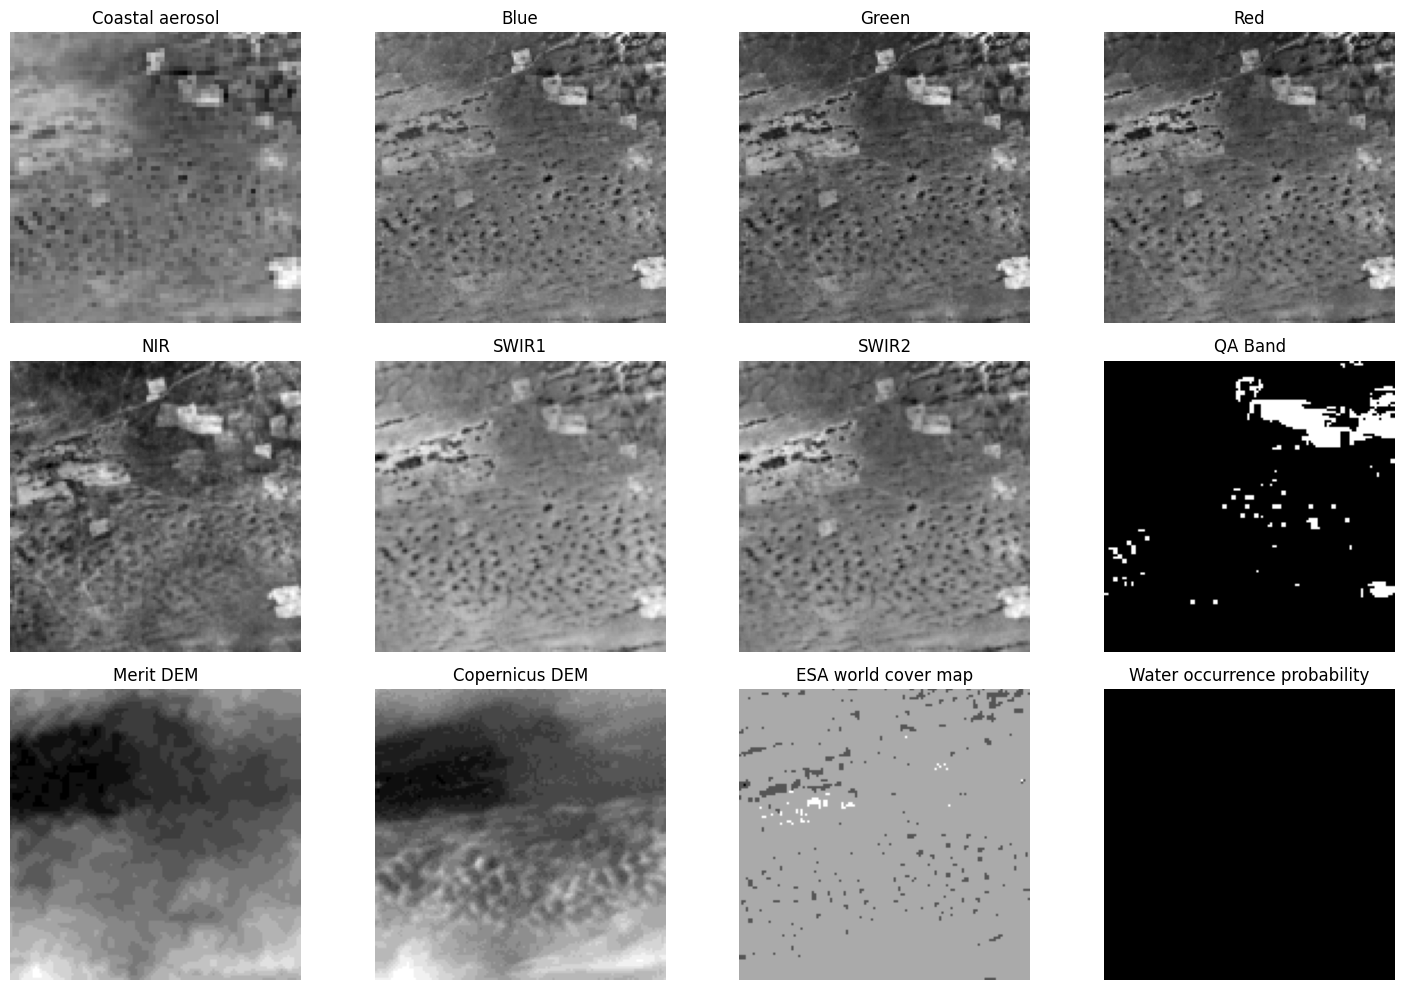

In [ ]:
# Example: Visualize the first image
if train_pairs:
    visualize_bands(train_pairs[0][0], mins, maxs)

## Function to Compute Water Indices (Feature Engineering)

In [ ]:
def compute_water_indices(img):
    # Channel indices based on diagram: 0: Coastal, 1: Blue, 2: Green, 3: Red, 4: NIR, 5: SWIR1, 6: SWIR2, ...
    blue = img[1]
    green = img[2]
    red = img[3]
    nir = img[4]
    swir1 = img[5]
    swir2 = img[6]

    ndwi = (green - nir) / (green + nir + 1e-10)
    mndwi = (green - swir1) / (green + swir1 + 1e-10)
    awei_sh = 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)
    ## New:
    awei_ns = blue + 2.5 * green - 1.5 * (nir + swir1) - 0.25 * swir2
    ndvi = (nir - red) / (nir + red + 1e-10)

    indices = np.stack([ndwi, mndwi, awei_sh, awei_ns, ndvi], axis=0)
    img_with_indices = np.concatenate([img, indices], axis=0)  # Now (17, 128, 128)

    return img_with_indices

### Notes:

1. `NDWI` – **Normalized Difference Water Index**

* **Idea**: Water absorbs strongly in NIR, reflects in Green. So water → high positive NDWI, vegetation/soil → low or negative NDWI.

* **Benefit**: Helps model distinguish water from vegetation/soil where reflectance looks similar in RGB.

2. `MNDWI` - **Modified NDWI**

* **Idea**: Replaces NIR with SWIR, because SWIR is even more absorbed by water.

* **Benefit**: Suppresses built-up land and dark features (roads, shadows) that NDWI sometimes confuses as water.

3. `NDVI` - **Normalized Difference Vegetation Index**

* **Idea**: Vegetation reflects strongly in NIR, absorbs Red.

* **Benefit**: Separates vegetation from water and shadows. Even though it's not a water index, it gives the model “anti-water” info, great for false positives.

4. `AWEI_SH` - **Automated Water Extraction Index (Shadow version)**

* **Idea**: Targets shadowed regions, which NDWI/MNDWI confuse with water.

* **Benefit**: Reduces false positives from mountain/shadow areas.

5. `AWEI_NSH` - **Automated Water Extraction Index (Non-shadow version)**

* **Idea**: Optimized for non-shadow areas, where urban features confuse NDWI.

* **Benefit**: Helps in cities/built-up areas where water and asphalt look similar.

6. `AWEI` - **Automated Water Extraction Index**

This is what I have above in the code, it matches the AWEI_SH (shadow version).

from the original paper by Xu.

**AWEI shadow:**

idx["AWEI_SH"] = 4*(g - s1) - (0.25*n + 2.75*s2)

**AWEI non-shadow:**

idx["AWEI_NSH"] = g - (r + 2.5*n + 1.5*s1 + 0.25*s2)

## Function to Get Feature Importances Using Random Forest

In [ ]:
def get_feature_importances(train_pairs, mins, maxs, sample_frac=0.01):
    data_list = []
    label_list = []
    feature_names = [
        'Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2',
        'QA Band', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability',
        'NDWI', 'MNDWI', 'AWEI-Shadow', 'AWEI-Non-Shadow', 'NDVI'
    ]
    for img_path, mask_path in train_pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        img = compute_water_indices(img)  # (17, 128, 128)

        mask = load_mask(mask_path)

        flat_img = img.reshape(17, -1).T  # (16384, 17)

        flat_mask = mask.flatten()  # (16384,)

        num_samples = int(len(flat_mask) * sample_frac)
        indices = np.random.choice(len(flat_mask), num_samples, replace=False)
        data_list.append(flat_img[indices])
        label_list.append(flat_mask[indices])
    data = np.vstack(data_list)
    labels = np.hstack(label_list)
    clf = RandomForestClassifier(n_estimators=300, random_state=42)
    clf.fit(data, labels)
    importances = clf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    for idx in sorted_indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    # Return top features (e.g., all for now)
    return feature_names, importances

In [ ]:
# Compute and print feature importances
feature_names, importances = get_feature_importances(train_pairs, mins, maxs)

NDWI: 0.1603
NDVI: 0.1300
AWEI-Non-Shadow: 0.1295
MNDWI: 0.0815
AWEI-Shadow: 0.0777
Merit DEM: 0.0581
NIR: 0.0532
SWIR1: 0.0517
Copernicus DEM: 0.0489
SWIR2: 0.0395
Water occurrence probability: 0.0368
Coastal aerosol: 0.0256
Red: 0.0256
ESA world cover map: 0.0250
Green: 0.0241
Blue: 0.0236
QA Band: 0.0090


## Function to get Quick per-band diagnostics

In [ ]:
import pandas as pd

# images: list/array of shape (N, C, H, W) for your dataset (use a sample subset if large)
# band_names: list of band names

import numpy as np
import pandas as pd

def band_diagnostics(train_pairs, mins, maxs, sample_frac=0.01, feature_names=None):
    data_list = []
    for img_path, mask_path in train_pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        img = compute_water_indices(img)  # (C, H, W)
        flat_img = img.reshape(img.shape[0], -1).T  # (pixels, C)
        num_samples = int(flat_img.shape[0] * sample_frac)
        indices = np.random.choice(flat_img.shape[0], num_samples, replace=False)
        data_list.append(flat_img[indices])
    data = np.vstack(data_list)  # (N_samples, C)

    stats = []
    for i in range(data.shape[1]):
        band = data[:, i]
        stats.append({
            "Band": feature_names[i] if feature_names else f"Band {i}",
            "Min": float(band.min()),
            "Max": float(band.max()),
            "Mean": float(band.mean()),
            "Std": float(band.std()),
            "Pct_zeros": float((band == 0).sum() / len(band))
        })
    df = pd.DataFrame(stats)
    print(df)
    return df

In [ ]:
band_diagnostics(train_pairs, mins, maxs, sample_frac=0.01, feature_names=feature_names)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


                            Band       Min       Max      Mean       Std  \
0                Coastal aerosol  0.139304  0.908805  0.225430  0.035844   
1                           Blue  0.067323  0.725601  0.149721  0.031745   
2                          Green  0.044830  0.683110  0.122098  0.036149   
3                            Red  0.037887  0.669382  0.125577  0.047271   
4                            NIR  0.016243  0.450132  0.154001  0.064569   
5                          SWIR1  0.011420  0.549176  0.148724  0.076302   
6                          SWIR2  0.011204  0.688427  0.109191  0.064199   
7                        QA Band  0.000000  1.000000  0.196962  0.253010   
8                      Merit DEM  0.000000  0.995507  0.710819  0.106151   
9                 Copernicus DEM  0.000000  0.984342  0.073089  0.125608   
10           ESA world cover map  0.000000  1.000000  0.276096  0.219911   
11  Water occurrence probability  0.000000  0.936937  0.081550  0.241625   
12          

Band       Min       Max      Mean       Std  \
0                Coastal aerosol  0.139304  0.908805  0.225430  0.035844   
1                           Blue  0.067323  0.725601  0.149721  0.031745   
2                          Green  0.044830  0.683110  0.122098  0.036149   
3                            Red  0.037887  0.669382  0.125577  0.047271   
4                            NIR  0.016243  0.450132  0.154001  0.064569   
5                          SWIR1  0.011420  0.549176  0.148724  0.076302   
6                          SWIR2  0.011204  0.688427  0.109191  0.064199   
7                        QA Band  0.000000  1.000000  0.196962  0.253010   
8                      Merit DEM  0.000000  0.995507  0.710819  0.106151   
9                 Copernicus DEM  0.000000  0.984342  0.073089  0.125608   
10           ESA world cover map  0.000000  1.000000  0.276096  0.219911   
11  Water occurrence probability  0.000000  0.936937  0.081550  0.241625   
12                          NDWI -0.585064  0.718440 -0.071883  0.254993   
13                         MNDWI -0.482770  0.944214 -0.032386  0.303701   
14                   AWEI-Shadow -3.386841  2.458303 -0.445279  0.450731   
15               AWEI-Non-Shadow -0.676004  1.715345 -0.026420  0.201417   
16                          NDVI -0.669040  0.707002  0.068301  0.268468   

    Pct_zeros  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.000000  
5    0.000000  
6    0.000000  
7    0.518958  
8    0.019134  
9    0.000025  
10   0.233305  
11   0.805516  
12   0.000000  
13   0.000000  
14   0.000000  
15   0.000000  
16   0.000000

If any band has tiny variance or is almost constant → strongly consider dropping.

**How to interpret:**

* Tiny std (~0 or <0.01) → feature is basically constant, provides no discrimination → safe to drop.

* Very high % zeros (>95%) → either a mask band with rare coverage (e.g., cirrus, QA) or a resampling artifact. Probably not useful unless you know it encodes something special.

* Extremely skewed values (min = max, or weird scaling) → check preprocessing; may not be reliable.

## Function to get Correlation / Redundancy matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def band_correlation(train_pairs, mins, maxs, sample_frac=0.01, feature_names=None):
    data_list = []
    for img_path, mask_path in train_pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        img = compute_water_indices(img)
        flat_img = img.reshape(img.shape[0], -1).T
        num_samples = int(flat_img.shape[0] * sample_frac)
        indices = np.random.choice(flat_img.shape[0], num_samples, replace=False)
        data_list.append(flat_img[indices])
    data = np.vstack(data_list)

    df = pd.DataFrame(data, columns=feature_names if feature_names else None)
    corr = df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=False, cmap="coolwarm", xticklabels=feature_names, yticklabels=feature_names)
    plt.title("Band Correlation Matrix")
    plt.show()

    return corr

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


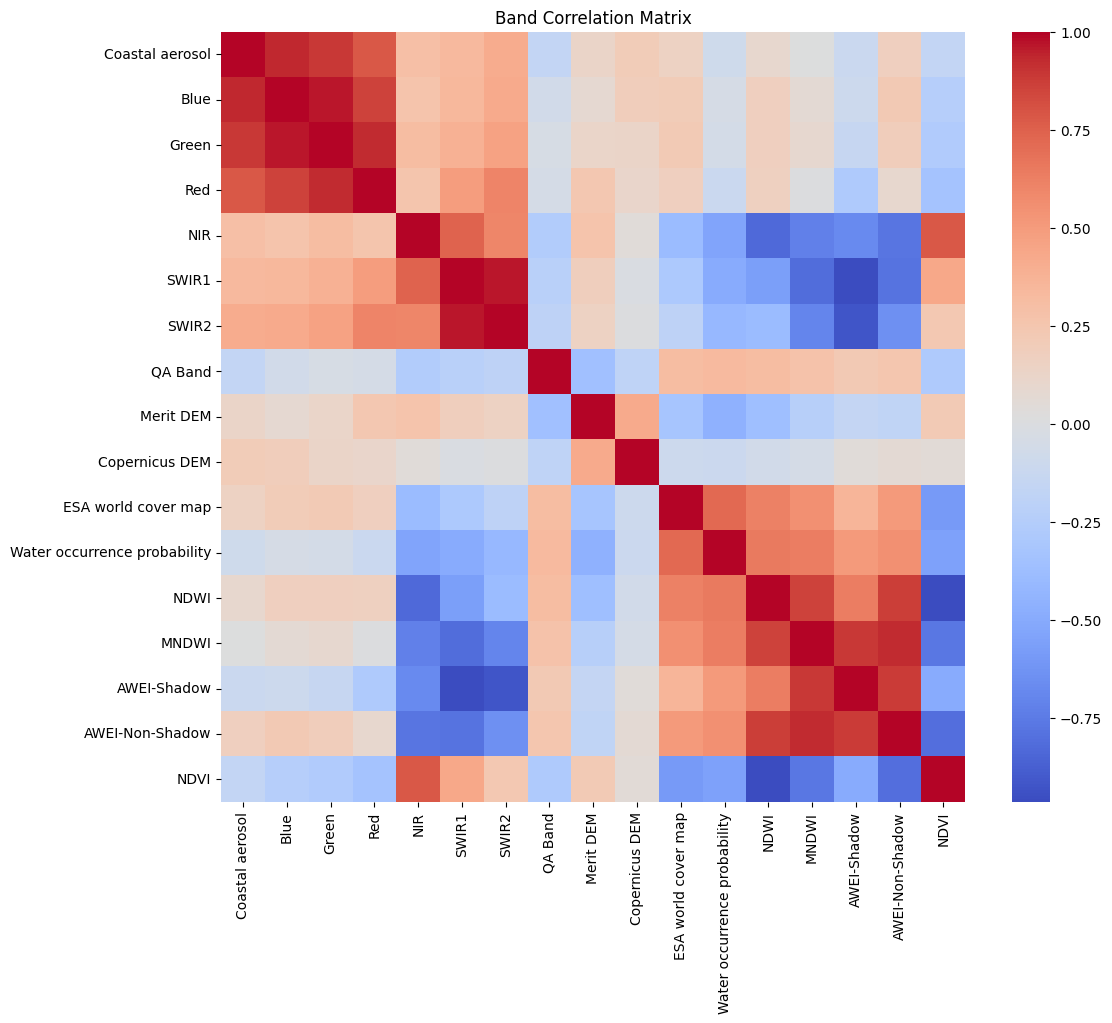

In [ ]:
corr_matrix = band_correlation(train_pairs, mins, maxs, sample_frac=0.01, feature_names=feature_names)

**How to interpret:**

- If two features are >0.95 correlated, they are redundant. Keep only one unless you have tons of data.

- Example: NDWI may be highly correlated with MNDWI in some environments; DEM and Copernicus DEM could also overlap.

- Rule of thumb:

  - Keep the more interpretable or higher-resolution feature.

  - Drop the redundant one to reduce dimensionality / overfitting risk.

## Function to get Mutual Information vs Ground Truth (Feature Importance)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def band_mutual_information(train_pairs, mins, maxs, sample_frac=0.01, feature_names=None):
    data_list, label_list = [], []
    for img_path, mask_path in train_pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        img = compute_water_indices(img)
        mask = load_mask(mask_path)

        flat_img = img.reshape(img.shape[0], -1).T
        flat_mask = mask.flatten()

        num_samples = int(flat_mask.size * sample_frac)
        indices = np.random.choice(flat_mask.size, num_samples, replace=False)

        data_list.append(flat_img[indices])
        label_list.append(flat_mask[indices])

    data = np.vstack(data_list)
    labels = np.hstack(label_list)

    mi = mutual_info_classif(data, labels, discrete_features=False, random_state=42)
    results = sorted(zip(feature_names if feature_names else range(data.shape[1]), mi), key=lambda x: x[1], reverse=True)

    print("Mutual Information per Feature:")
    for name, score in results:
        print(f"{name}: {score:.4f}")

    return results

In [ ]:
mi_scores = band_mutual_information(train_pairs, mins, maxs, sample_frac=0.01, feature_names=feature_names)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Mutual Information per Feature:
Merit DEM: 0.2978
AWEI-Non-Shadow: 0.2810
NDWI: 0.2805
Copernicus DEM: 0.2731
MNDWI: 0.2687
NDVI: 0.2643
AWEI-Shadow: 0.2580
QA Band: 0.2576
NIR: 0.2572
SWIR1: 0.2415
Water occurrence probability: 0.2139
SWIR2: 0.2136
ESA world cover map: 0.1930
Red: 0.0799
Blue: 0.0361
Green: 0.0296
Coastal aerosol: 0.0233


**What you get:**

numeric score for each band → higher means more predictive of water vs non-water.

**How to interpret:**

* High MI score (near top of list) → band strongly helps separate water. Keep it.

* Low MI score (near 0) → little to no information gain.

* Compare indices to raw bands: often NDWI, MNDWI, AWEI, NDVI rank high. Some raw bands (e.g., Coastal aerosol, Cirrus, QA) may rank low.

Use this to prioritize which features truly drive segmentation.

## Load Training and Testing Data

In [ ]:
def load_dataset(pairs, mins, maxs, use_indices=True):
    images = []
    masks = []
    for img_path, mask_path in pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)   # normalization
        if use_indices:
            img = compute_water_indices(img)  # Use 17 channels if True
        mask = load_mask(mask_path)
        images.append(img)
        masks.append(mask)
    return np.stack(images), np.stack(masks)

In [ ]:
# Load with indices (17 channels)
num_channels = 17
train_images, train_masks = load_dataset(train_pairs, mins, maxs, use_indices=True)
test_images, test_masks = load_dataset(test_pairs, mins, maxs, use_indices=True)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


## Function to Visualize Random Images in RGB Format

In [ ]:
def visualize_random_rgb(images, num_samples=3):
    # Ensure images are in channel-first format (C, H, W) and select random indices
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

    for idx, ax in zip(indices, axs):
        # Use bands 3 (Red), 2 (Green), 1 (Blue) for RGB approximation
        # Transpose to (H, W, C) and select RGB bands
        rgb = images[idx][[3, 2, 1]]  # Shape: (3, 128, 128)
        rgb = np.transpose(rgb, (1, 2, 0))  # Shape: (128, 128, 3)
        rgb = np.clip(rgb, 0, 1)  # Ensure values are in [0, 1] for display
        ax.imshow(rgb)
        ax.set_title(f'Image {idx} (RGB approx)')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

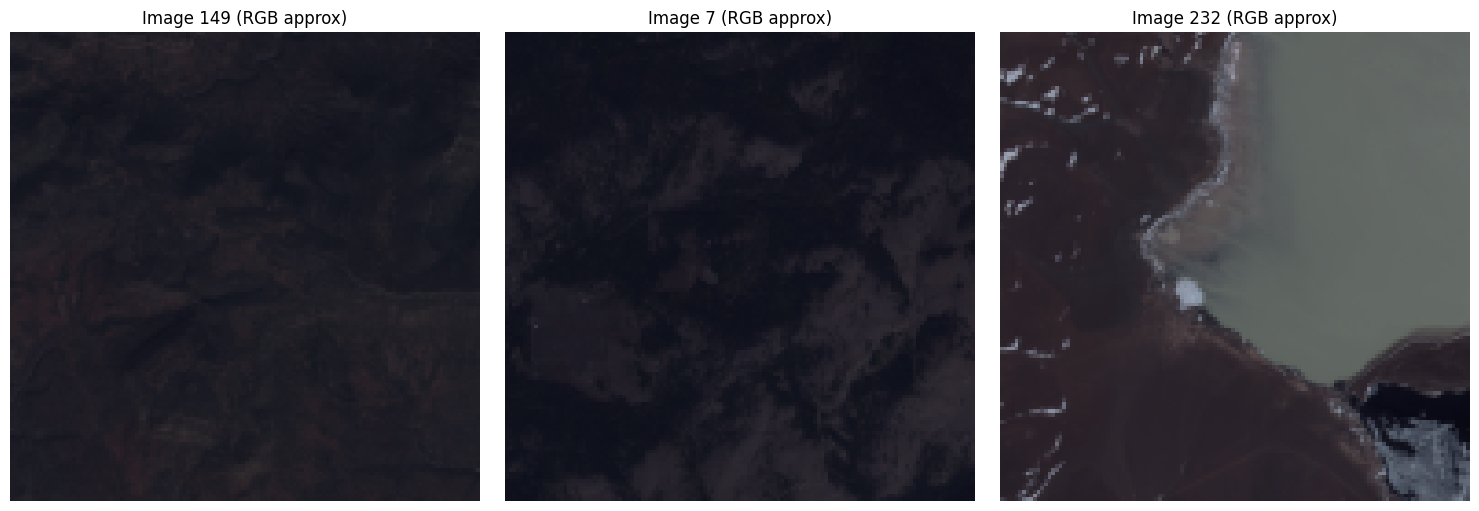

In [ ]:
# Visualize random RGB images from training set before augmentation
visualize_random_rgb(train_images)

## Augmentations

### Visualizing Individual Augmentations

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import os # Import os for os.path.basename

def visualize_individual_augmentations(original_pairs, mins, maxs, transform_compose, num_samples=1):
    # Select random pairs to visualize
    selected_pairs = random.sample(original_pairs, min(num_samples, len(original_pairs)))

    for img_path, mask_path in selected_pairs:
        # Load and normalize the original image
        original_img = load_image(img_path)
        original_img_normalized = normalize_image(original_img.copy(), mins, maxs) # Use a copy

        # Create RGB approximation for display
        if original_img_normalized.shape[0] > 3:
            original_rgb = original_img_normalized[[3, 2, 1], :, :]
            original_rgb = (original_rgb - original_rgb.min()) / (original_rgb.max() - original_rgb.min() + 1e-6)
            original_rgb_display = np.transpose(original_rgb, (1, 2, 0))
        else:
             print(f"Warning: Not enough bands ({original_img_normalized.shape[0]}) to create RGB image for visualization. Showing first band.")
             original_rgb_display = original_img_normalized[0, :, :]

        # Load the original mask
        original_mask = load_mask(mask_path)

        plt.suptitle(f"Visualizing Augmentations for Sample: {os.path.basename(img_path)}", horizontalalignment='center', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle


        # Iterate through each individual transform in the Compose
        for i, transform in enumerate(transform_compose.transforms):
            # Apply only this single transform
            single_transform_compose = A.Compose([transform])

            # Albumentations expects HWC format
            original_img_normalized_hwc = original_img_normalized.transpose(1, 2, 0) # (H, W, C)

            # Apply the single augmentation
            augmented = single_transform_compose(image=original_img_normalized_hwc, mask=original_mask)
            augmented_img = augmented['image'].transpose(2, 0, 1) # Back to (C, H, W)
            augmented_mask = augmented['mask']

            # Create RGB approximation for the augmented image
            if augmented_img.shape[0] > 3:
                augmented_rgb = augmented_img[[3, 2, 1], :, :]
                augmented_rgb = (augmented_rgb - augmented_rgb.min()) / (augmented_rgb.max() - augmented_rgb.min() + 1e-6)
                augmented_rgb_display = np.transpose(augmented_rgb, (1, 2, 0))
            else:
                 augmented_rgb_display = augmented_img[0, :, :]


            # Plotting
            fig, axs = plt.subplots(1, 4, figsize=(16, 4)) # Original RGB, Original Mask, Augmented RGB, Augmented Mask

            # Original RGB
            if original_rgb_display.ndim == 3:
                axs[0].imshow(original_rgb_display)
                axs[0].set_title('Original RGB')
            else:
                 axs[0].imshow(original_rgb_display, cmap='gray')
                 axs[0].set_title('Original (Band 1)')
            axs[0].axis('off')

            # Original Mask
            axs[1].imshow(original_mask, cmap='gray')
            axs[1].set_title('Original Mask')
            axs[1].axis('off')

            # Augmented RGB
            if augmented_rgb_display.ndim == 3:
                axs[2].imshow(augmented_rgb_display)
                axs[2].set_title('Augmented RGB')
            else:
                 axs[2].imshow(augmented_rgb_display, cmap='gray')
                 axs[2].set_title('Augmented (Band 1)')
            axs[2].axis('off')


            # Augmented Mask
            axs[3].imshow(augmented_mask, cmap='gray')
            axs[3].set_title('Augmented Mask')
            axs[3].axis('off')

            # Add the name of the augmentation above the plots
            plt.suptitle(f"Augmentation: {type(transform).__name__}", fontsize=14)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
            plt.show()

Visualizes the effect of each individual augmentation within a Compose transform.

**Args:**

* original_pairs (list): A list of (image_path, mask_path) tuples for the original dataset.

* mins (np.ndarray): Minimum values for each channel from the training set.

* maxs (np.ndarray): Maximum values for each channel from the training set.

* transform_compose (albumentations.Compose): The augmentation transform containing individual transforms.

* num_samples (int): Number of random samples to visualize for each augmentation.

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


<Figure size 640x480 with 0 Axes>

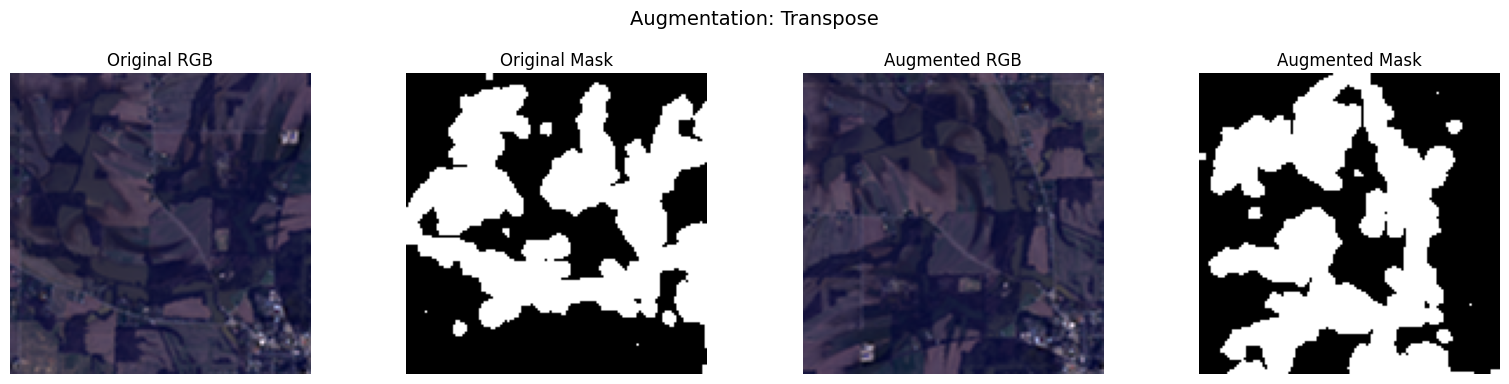

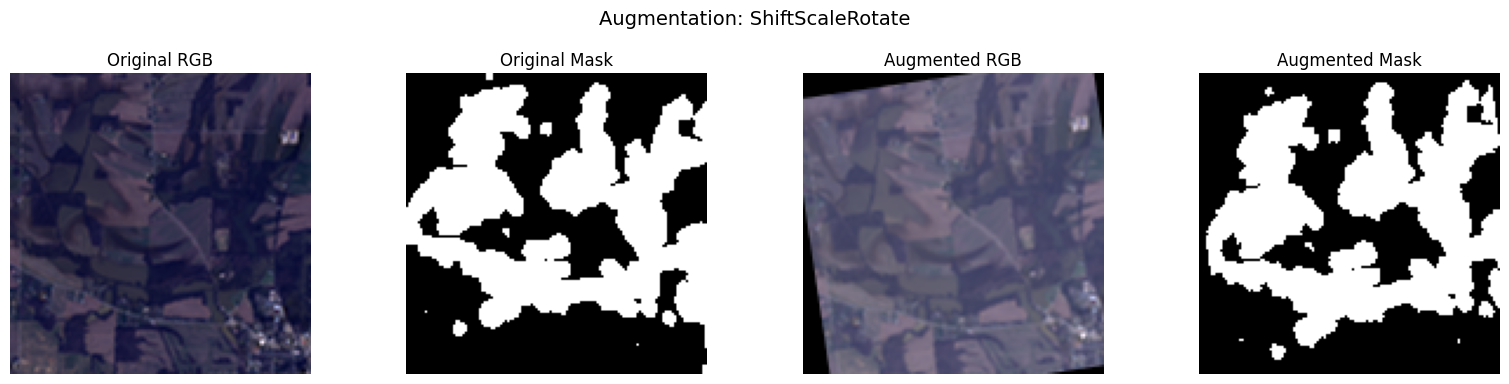

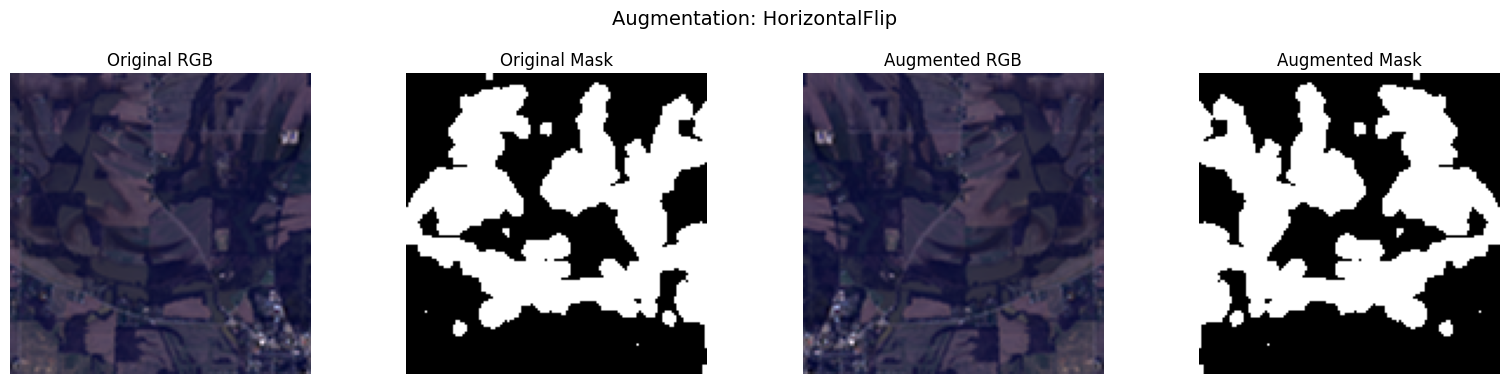

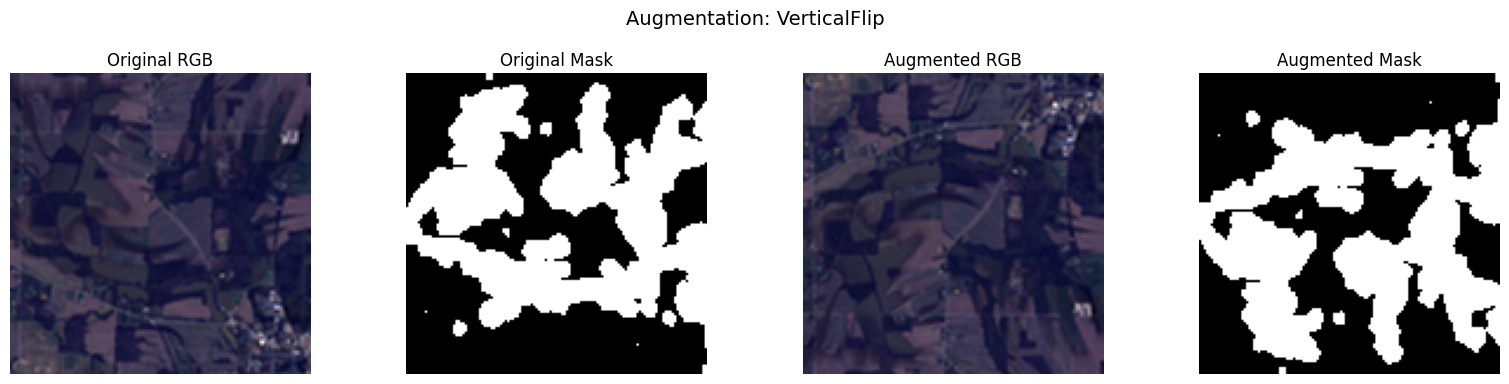

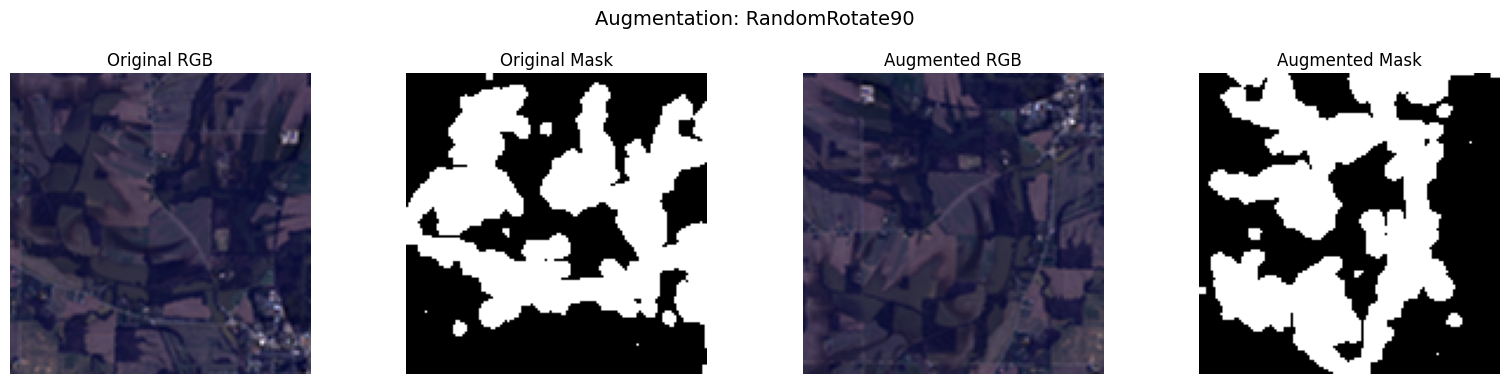

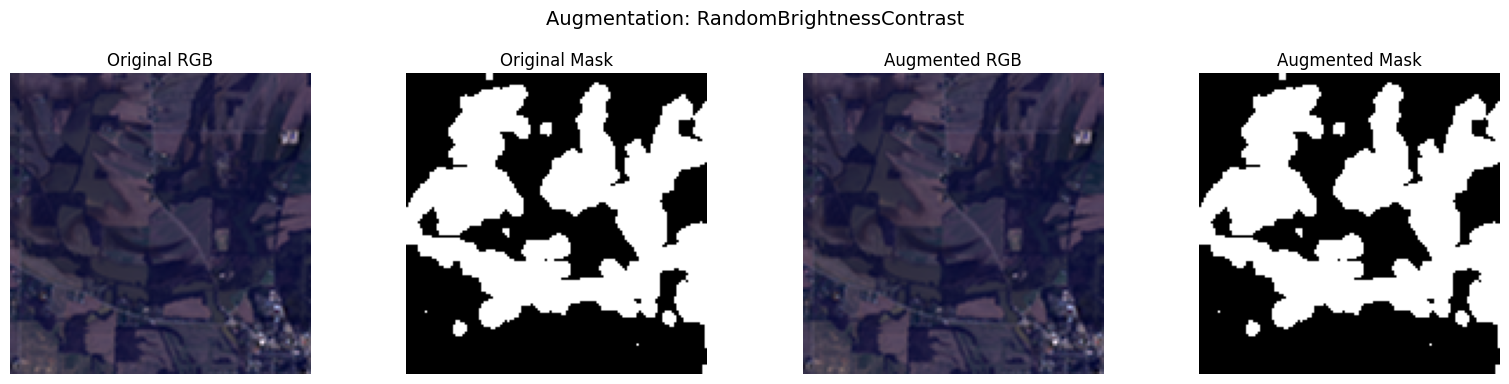

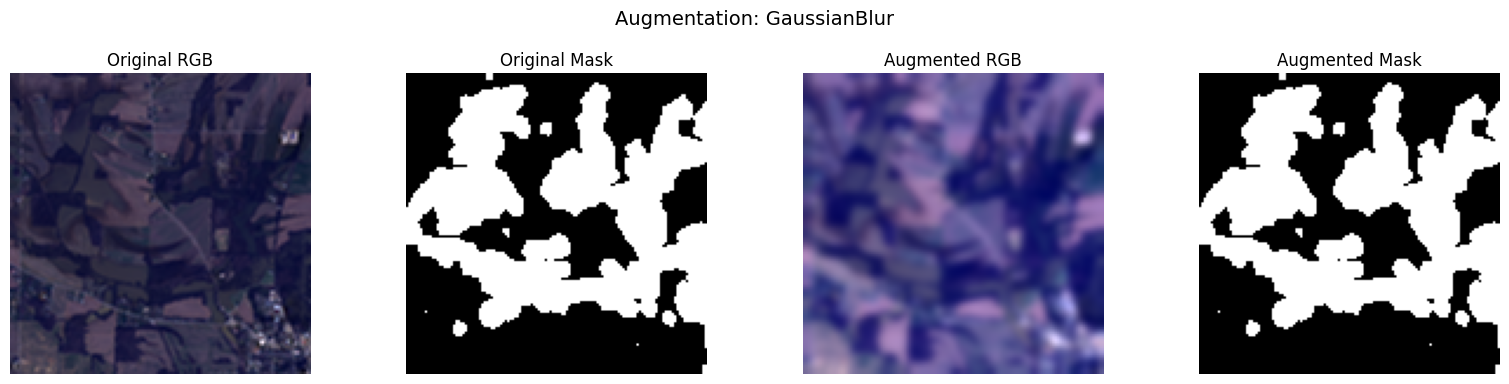

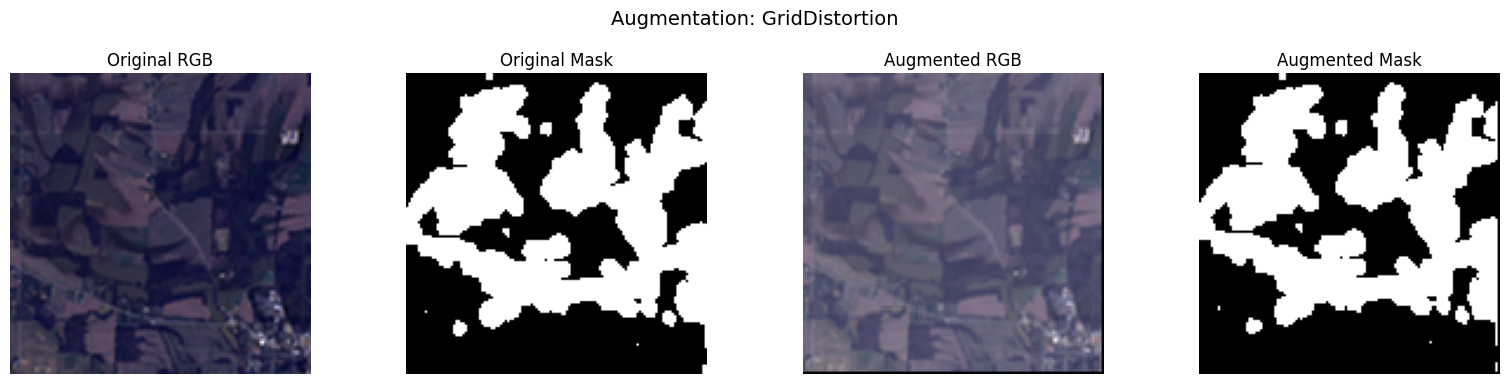

In [ ]:
# Create an Albumentations transform instance
transform_for_viz_ind = A.Compose([
        #A.Flip(p=0.5),
        A.Transpose(p=1),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=1),
        # A.GaussNoise(p=0.3),

        A.HorizontalFlip(p=1),
        A.VerticalFlip(p=1),
        A.RandomRotate90(p=1),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=1),

        # A.RandomFlip(p=0.5),
        # A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),   # mild noise
        # A.GaussNoise(std_range=(0.05, 0.1), mean_range=(0.0,0.0), p=1),   # mild noise (0.05, 0.1)
        A.GaussianBlur(blur_limit=1, p=1),          # small blur  (2)

        A.GridDistortion(distort_limit=0.05, p=1),  # small safe distortion (0.05)
    ])

visualize_individual_augmentations(train_pairs, mins, maxs, transform_for_viz_ind, num_samples=1)

### Visualizing the Augmentations Combined

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

def visualize_augmentations(original_pairs, mins, maxs, transform, num_samples=3):
    selected_pairs = random.sample(original_pairs, min(num_samples, len(original_pairs)))

    for img_path, mask_path in selected_pairs:
        # Load and normalize the original image
        original_img = load_image(img_path)
        original_img_normalized = normalize_image(original_img.copy(), mins, maxs) # Use a copy to avoid modifying original array

        # Create RGB approximation for display (assuming bands 3, 2, 1 are Red, Green, Blue)
        if original_img_normalized.shape[0] > 3:
            original_rgb = original_img_normalized[[3, 2, 1], :, :]
            # Normalize RGB for display purposes (optional, depending on range)
            original_rgb = (original_rgb - original_rgb.min()) / (original_rgb.max() - original_rgb.min() + 1e-6)
            original_rgb_display = np.transpose(original_rgb, (1, 2, 0))
        else:
             print(f"Warning: Not enough bands ({original_img_normalized.shape[0]}) to create RGB image for visualization. Showing first band.")
             original_rgb_display = original_img_normalized[0, :, :] # Show first band

        # Load the original mask
        original_mask = load_mask(mask_path)

        # Apply augmentation
        # Albumentations expects HWC format, so transpose before applying and transpose back after
        original_img_normalized_hwc = original_img_normalized.transpose(1, 2, 0) # (H, W, C)
        augmented = transform(image=original_img_normalized_hwc, mask=original_mask)
        augmented_img = augmented['image'].transpose(2, 0, 1) # Back to (C, H, W)
        augmented_mask = augmented['mask']

        # Create RGB approximation for the augmented image (using the same bands and normalization)
        if augmented_img.shape[0] > 3:
            augmented_rgb = augmented_img[[3, 2, 1], :, :]
            augmented_rgb = (augmented_rgb - augmented_rgb.min()) / (augmented_rgb.max() - augmented_rgb.min() + 1e-6)
            augmented_rgb_display = np.transpose(augmented_rgb, (1, 2, 0))
        else:
             augmented_rgb_display = augmented_img[0, :, :] # Show first band


        # Plotting
        fig, axs = plt.subplots(1, 4, figsize=(16, 4)) # 4 subplots: Original RGB, Original Mask, Augmented RGB, Augmented Mask

        # Original RGB
        if original_rgb_display.ndim == 3:
            axs[0].imshow(original_rgb_display)
            axs[0].set_title('Original RGB')
        else:
             axs[0].imshow(original_rgb_display, cmap='gray')
             axs[0].set_title('Original (Band 1)')
        axs[0].axis('off')

        # Original Mask
        axs[1].imshow(original_mask, cmap='gray')
        axs[1].set_title('Original Mask')
        axs[1].axis('off')

        # Augmented RGB
        if augmented_rgb_display.ndim == 3:
            axs[2].imshow(augmented_rgb_display)
            axs[2].set_title('Augmented RGB')
        else:
            axs[2].imshow(augmented_rgb_display, cmap='gray')
            axs[2].set_title('Augmented (Band 1)')
        axs[2].axis('off')


        # Augmented Mask
        axs[3].imshow(augmented_mask, cmap='gray')
        axs[3].set_title('Augmented Mask')
        axs[3].axis('off')

        plt.suptitle(f"Augmentation Sample {original_pairs.index((img_path, mask_path)) + 1}") # Optional: add a main title per sample
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
        plt.show()

Visualizes random samples of original and augmented image-mask pairs.

Args:

* original_pairs (list): A list of (image_path, mask_path) tuples for the original dataset.
* mins (np.ndarray): Minimum values for each channel from the training set.
* maxs (np.ndarray): Maximum values for each channel from the training set.
* transform (albumentations.Compose): The augmentation transform to apply.
* num_samples (int): Number of random samples to visualize.

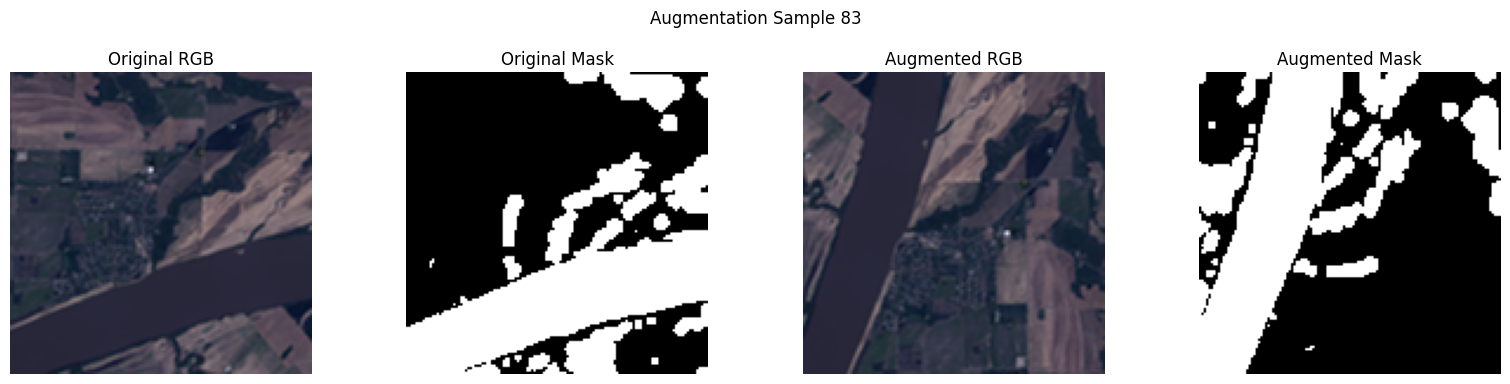

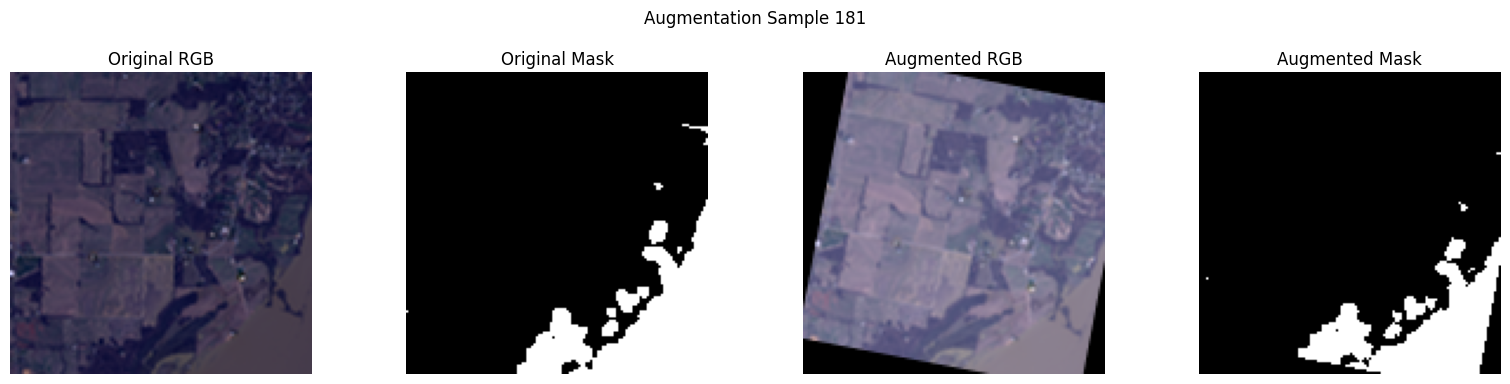

In [ ]:
# Create an Albumentations transform instance
transform_for_viz = A.Compose([
        #A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        # A.GaussNoise(p=0.3),

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.5),

        # A.RandomFlip(p=0.5),
        # A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),   # mild noise
        # A.GaussNoise(std_range=(0.05, 0.1), mean_range=(0.0,0.0), p=0.2),   # mild noise
        A.GaussianBlur(blur_limit=1, p=0.2),          # small blur

        A.GridDistortion(distort_limit=0.05, p=0.2),  # small safe distortion
    ])

visualize_augmentations(train_pairs, mins, maxs, transform_for_viz, num_samples=2)

### Actual Data Augmentation for the Train Images and Masks

In [ ]:
def augment_data(images, masks, num_augs=3):
    transform = A.Compose([
        #A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        # A.GaussNoise(p=0.3),

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.5),

        # A.RandomFlip(p=0.5),
        # A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),   # mild noise
        # A.GaussNoise(std_range=(0.05, 0.1), mean_range=(0.0,0.0), p=0.2),   # mild noise
        A.GaussianBlur(blur_limit=1, p=0.2),          # small blur

        A.GridDistortion(distort_limit=0.05, p=0.2),  # small safe distortion
    ])
    aug_images = list(images)
    aug_masks = list(masks)
    for i in range(len(images)):
        for _ in range(num_augs):
            transposed_img = images[i].transpose(1, 2, 0)  # (128, 128, C)
            tr = transform(image=transposed_img, mask=masks[i])
            aug_img = tr['image'].transpose(2, 0, 1)  # Back to (C, 128, 128)
            aug_mask = tr['mask']
            aug_images.append(aug_img)
            aug_masks.append(aug_mask)
    return np.array(aug_images), np.array(aug_masks)

In [ ]:
train_images, train_masks = augment_data(train_images, train_masks)

## Prepare DataLoaders

In [ ]:
train_dataset = TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_masks[..., np.newaxis]))  # Masks: (N, 128, 128, 1)
test_dataset = TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_masks[..., np.newaxis]))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



---


# Model

## Define Model (Pretrained U-Net with ResNet34 Backbone)

In [ ]:
def get_model_resnet34(num_channels, classes=1, dropout_p=0.0):
    model = smp.Unet(
        encoder_name="resnet34",           # pretrained backbone
        encoder_weights="imagenet",        # load ImageNet weights, pretrained on 3-ch, first conv adapted to 17
        in_channels=num_channels,          # 17 spectral bands
        classes=classes,                   # binary segmentation
        # activation="sigmoid"               # last layer activation function
        # decoder_use_norm=True,                # defaults to BatchNormalization
        decoder_use_norm="batchnorm",
        activation=None                    # outputs raw logits
    )

    # fix conv1 mapping (### this is to encode weights of 'image_net' to the actual rgb channels as they were supposed to)
    conv1 = model.encoder.conv1  # shape (64, 17, 7, 7) (number of output filters, input_channels, kernel_height, kernel_width)

    # Dataset channel positions for RGB, in the 17-channel input
    red_idx, green_idx, blue_idx = 3, 2, 1

    with torch.no_grad():
        # Copy pretrained ImageNet weights to the correct channels
        conv1.weight[:, red_idx]   = conv1.weight[:, 0].clone() # copy pretrained R → dataset's Red
        conv1.weight[:, green_idx] = conv1.weight[:, 1].clone() # pretrained G → dataset's Green
        conv1.weight[:, blue_idx]  = conv1.weight[:, 2].clone() # pretrained B → dataset's Blue

        # Reset the first 3 slots so they don’t overlap
        nn.init.kaiming_normal_(conv1.weight[:, 0:3])

    # Add dropout to decoder blocks
    for i, block in enumerate(model.decoder.blocks):
        block.add_module("dropout", nn.Dropout2d(p=dropout_p))

    return model

In [ ]:
def get_model_resnet50(num_channels, classes=1):
    model = smp.Unet(
        encoder_name="resnet50",           # pretrained backbone
        encoder_weights="imagenet",        # load ImageNet weights, pretrained on 3-ch, first conv adapted to 17
        in_channels=num_channels,          # 17 spectral bands
        classes=classes,                   # binary segmentation
        # activation="sigmoid"               # last layer activation function
        # decoder_use_norm=True,                # defaults to BatchNormalization
        decoder_use_norm="batchnorm",
        activation=None                    # outputs raw logits
    )

    # fix conv1 mapping (### this is to encode weights of 'image_net' to the actual rgb channels as they were supposed to)
    conv1 = model.encoder.conv1

    # Dataset channel positions for RGB, in the 17-channel input
    red_idx, green_idx, blue_idx = 3, 2, 1

    with torch.no_grad():
        # Copy pretrained ImageNet weights to the correct channels
        conv1.weight[:, red_idx]   = conv1.weight[:, 0].clone() # copy pretrained R → dataset's Red
        conv1.weight[:, green_idx] = conv1.weight[:, 1].clone() # pretrained G → dataset's Green
        conv1.weight[:, blue_idx]  = conv1.weight[:, 2].clone() # pretrained B → dataset's Blue

        # Reset the first 3 slots so they don’t overlap
        nn.init.kaiming_normal_(conv1.weight[:, 0:3])

    return model

In [ ]:
def get_model_resnet101(num_channels, classes=1):
    model = smp.Unet(
        encoder_name="resnet101",          # pretrained backbone
        encoder_weights="imagenet",        # load ImageNet weights, pretrained on 3-ch, first conv adapted to 17
        in_channels=num_channels,          # 17 spectral bands
        classes=classes,                   # binary segmentation
        # activation="sigmoid"             # last layer activation function
        # decoder_use_norm=True,           # defaults to BatchNormalization
        decoder_use_norm="batchnorm",
        activation=None                    # outputs raw logits
    )

    # fix conv1 mapping (### this is to encode weights of 'image_net' to the actual rgb channels as they were supposed to)
    conv1 = model.encoder.conv1

    # Dataset channel positions for RGB, in the 17-channel input
    red_idx, green_idx, blue_idx = 3, 2, 1

    with torch.no_grad():
        # Copy pretrained ImageNet weights to the correct channels
        conv1.weight[:, red_idx]   = conv1.weight[:, 0].clone() # copy pretrained R → dataset's Red
        conv1.weight[:, green_idx] = conv1.weight[:, 1].clone() # pretrained G → dataset's Green
        conv1.weight[:, blue_idx]  = conv1.weight[:, 2].clone() # pretrained B → dataset's Blue

        # Reset the first 3 slots so they don’t overlap
        nn.init.kaiming_normal_(conv1.weight[:, 0:3])

    return model

In [ ]:
def get_model_efficientnet_b4(num_channels, classes=1):
    model = smp.Unet(
        encoder_name="efficientnet-b4",
        encoder_weights="imagenet",
        in_channels=num_channels,        # 17 bands
        classes=classes,                 # binary segmentation
        decoder_use_norm="batchnorm",
        activation=None
    )

    # EfficientNet uses _conv_stem instead of conv1
    conv_stem = model.encoder._conv_stem

    red_idx, green_idx, blue_idx = 3, 2, 1

    with torch.no_grad():
        conv_stem.weight[:, red_idx]   = conv_stem.weight[:, 0].clone()
        conv_stem.weight[:, green_idx] = conv_stem.weight[:, 1].clone()
        conv_stem.weight[:, blue_idx]  = conv_stem.weight[:, 2].clone()

        nn.init.kaiming_normal_(conv_stem.weight[:, 0:3])

    return model

In [ ]:
def get_model_efficientnet_b5(num_channels, classes=1):
    model = smp.Unet(
        encoder_name="efficientnet-b5",          # pretrained backbone
        encoder_weights="imagenet",
        in_channels=num_channels,        # 17 bands
        classes=classes,                 # binary segmentation
        decoder_use_norm="batchnorm",
        activation=None
    )

    # EfficientNet uses _conv_stem instead of conv1
    conv_stem = model.encoder._conv_stem

    red_idx, green_idx, blue_idx = 3, 2, 1

    with torch.no_grad():
        conv_stem.weight[:, red_idx]   = conv_stem.weight[:, 0].clone()
        conv_stem.weight[:, green_idx] = conv_stem.weight[:, 1].clone()
        conv_stem.weight[:, blue_idx]  = conv_stem.weight[:, 2].clone()

        nn.init.kaiming_normal_(conv_stem.weight[:, 0:3])

    return model

**decoder_use_norm:** Specifies normalization between Conv2D and activation.

*Accepts the following types:

- **True**: Defaults to "batchnorm".

- **False**: No normalization (nn.Identity).

- **str**: Specifies normalization type using default parameters. Available values:
"batchnorm", "identity", "layernorm", "instancenorm", "inplace".

### Notes

**Pretrained encoder with 15 channels**

You’re using encoder_weights="imagenet" (which has weights for 3-channel RGB).

SMP adapts the first conv layer for more channels (15 in your case), but only the first 3 channels are initialized with pretrained weights, the rest are usually zero-initialized.

This means your backbone is partially pretrained but the extra 12 channels are randomly initialized.

Not wrong, but training may be slower.

If you don’t want the partial mismatch, you can set `encoder_weights=None` (all layers random init).

**Although ResNet-34 only expects 3 channels originally, SMP handles this by adapting the first conv)**

unless you explicitly froze layers, your model is fully unfrozen.

In [ ]:
# @title
# def get_model(num_channels, classes=1, encoder_weights="imagenet"):
#     model = smp.Unet(
#         encoder_name="resnet34",
#         encoder_weights=encoder_weights,
#         in_channels=num_channels,
#         classes=classes,
#         activation="sigmoid"
#     )

#     # Adapt first conv layer if needed for different input channels
#     if encoder_weights is not None and num_channels != 3:
#         enc = model.encoder
#         try:
#             conv = None
#             # Common names for the first convolutional layer in popular backbones
#             if hasattr(enc, "conv1"):
#                 conv = enc.conv1
#             elif hasattr(enc, "layer0") and hasattr(enc.layer0, "conv1"):
#                 conv = enc.layer0.conv1
#             # Add checks for other potential first layer names if using different backbones
#             # elif hasattr(enc, "features") and hasattr(enc.features[0], "0"): # Example for some VGG-like
#             #     conv = enc.features[0][0]

#             if conv is not None:
#                 # Ensure the existing conv layer has 3 input channels initially if using imagenet weights
#                 if conv.in_channels == 3:
#                      with torch.no_grad():
#                         w = conv.weight  # shape (out, in, k, k)
#                         w0 = w[:, :3, :, :].clone()
#                         mean_ch = w0.mean(dim=1, keepdim=True)
#                         new_w = torch.zeros((w.shape[0], num_channels, w.shape[2], w.shape[3]), dtype=w.dtype, device=w.device)
#                         new_w[:, :3, :, :] = w0
#                         for c in range(3, num_channels):
#                             new_w[:, c:c+1, :, :] = mean_ch
#                         conv.weight.copy_(new_w)
#                         # Update the in_channels property
#                         conv.in_channels = num_channels
#                 else:
#                      print(f"Warning: First convolution layer has {conv.in_channels} input channels, not 3. Skipping channel adaptation.")

#             else:
#                  print("Warning: Could not find the first convolutional layer in the encoder.")

#         except Exception as e:
#             print("Warning adjusting first conv failed:", e)

#     return model

### Instancing the model

In [ ]:
# nn_model = get_model_resnet34(num_channels)

nn_model = get_model_resnet34(num_channels, dropout_p=0.5)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
# to see how many params are frozen vs trainable:

trainable = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
frozen    = sum(p.numel() for p in nn_model.parameters() if not p.requires_grad)
print(f"Trainable: {trainable:,} | Frozen: {frozen:,}")

Trainable: 24,480,273 | Frozen: 0


In [ ]:
# To freeze encoder

# for param in model.encoder.parameters():
    # param.requires_grad = False

# Training Setup

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# learning_rate = 1e-4
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_model.to(device)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-4)
dice_loss = smp.losses.DiceLoss(mode='binary') # applies sigmoid internally
bce_loss = nn.BCEWithLogitsLoss()  # expects raw logits
jaccard_loss = smp.losses.JaccardLoss(mode='binary')
# bce_loss = nn.BCELoss()
# def combined_loss(pred, target):
#     return 0.8 * dice_loss(pred, target) + 0.2 * bce_loss(pred, target)

# def combined_loss(pred, target):
#     return 0.3 * jaccard_loss(pred, target) + 0.5 * bce_loss(pred, target) + 0.2 * dice_loss(pred, target)

def combined_loss(pred, target):
    return jaccard_loss(pred, target) + bce_loss(pred, target) + dice_loss(pred, target)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=7, min_lr=1e-7)

# for the multiple runs, second and third losses
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7)

In segmentation, it's common to start with **BCE + Dice** combined:

* **BCE** handles pixel-wise classification.

* **Dice** handles class imbalance (small water bodies).

don't forget to change the **mode** to **min** if you change the scheduler to focus on validation loss

### IoU score from SMP

In [ ]:
import segmentation_models_pytorch as smp

# Initialize IoU metric for binary segmentation
# train_iou_metric = smp.metrics.iou_score(threshold=0.5)
# val_iou_metric   = smp.metrics.iou_score(threshold=0.5)

### It isn't a class, will use it in the loop itself

### Using BinaryJaccardIndex Metric (Jaccard is IoU) from torchmetrics

In [ ]:
!pip install torchmetrics

In [ ]:
# from torchmetrics.classification import BinaryJaccardIndex

# Initialize IoU metrics (once, outside the loop)
# train_iou_metric = BinaryJaccardIndex(threshold=0.5).to(device)
# val_iou_metric   = BinaryJaccardIndex(threshold=0.5).to(device)

### Issues:

1. **Mismatched activation**

* I used `nn.BCELoss()` which expects **probabilities in [0,1]**, but your model almost certainly outputs **logits** (raw values).

* Same with IoU: I thresholded `outputs > 0.5`, but `outputs` are logits, not probabilities.

-> That explains why IoU is stuck ~0.18: logits aren't comparable to masks without a `sigmoid`

2. **Dice loss (from smp)**

`smp.losses.DiceLoss(mode='binary')` **already applies sigmoid** internally, so it works fine.

But when you combine it with raw `BCELoss` (without sigmoid), they aren't on the same scale. One loss is computed on probabilities, the other on logits.

### Fix

You should make everything consistent:

**Option A: Use BCEWithLogitsLoss**

* Replace `nn.BCELoss()` with `nn.BCEWithLogitsLoss()`

* Keep your model outputs as logits (no sigmoid in the model forward).

* Update your IoU to apply sigmoid before thresholding.

**Option B: Stick with nn.BCELoss**

If you really want to use plain `BCELoss`, then you must add a sigmoid inside your forward pass or before passing predictions into the loss:



```
bce_loss = nn.BCELoss()

def combined_loss(pred, target):
    probs = torch.sigmoid(pred)
    return 0.5 * dice_loss(probs, target) + 0.5 * bce_loss(probs, target)

```

But this is less efficient (double sigmoid). Option A is cleaner.

### Remarks

#### Include this in the training loop, if not normalized and normalize the masks

In [ ]:
for images, masks in train_loader:
    print(torch.unique(masks))
    break  # just to see one batch

tensor([0., 1.])


In [ ]:
for images, masks in test_loader:
    print(torch.unique(masks))
    break

tensor([0., 1.])


This checks whether your training masks are `[0, 1]` (good) or `[0, 255]` (need normalization).

If you see tensor([0., 1.]) → perfect, masks are binary.

If you see something like tensor([0., 255.]) → you must normalize:

In [ ]:
# masks = masks / 255.0

## Training Loop

#### by `val_iou` (I think is better if you use different losses)

In [ ]:
import segmentation_models_pytorch as smp

num_epochs = 120

# num_epochs = 160 # (60 + 40 + 40)

# num_epochs = 60
# num_epochs = 50
# num_epochs = 50

# num_epochs = 120

train_losses = []
val_losses = []
train_ious = []
val_ious = []

best_val_iou = 0.0
best_model_path_val_iou = 'best_model_val_iou.pth'

for epoch in range(num_epochs):

    loss_fn = combined_loss
    loss_name = "Combined"

    # loss_fn = bce_loss
    # loss_name = "BCE"

    # loss_fn = jaccard_loss
    # loss_name = "jaccard"

    # loss_fn = dice_loss
    # loss_name = "Dice"

    # Choose loss function based on stage
    # if epoch < 60:
    #     loss_fn = bce_loss
    #     loss_name = "BCE"
    # elif epoch < 100:
    #     loss_fn = jaccard_loss
    #     loss_name = "jaccard"
    # else:
    #     loss_fn = dice_loss
    #     loss_name = "Dice"

    # ---------------- TRAINING ----------------
    nn_model.train()
    train_loss = 0.0
    train_iou_total = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float().squeeze(-1).unsqueeze(1)  # [B, 1, H, W]

        optimizer.zero_grad()
        outputs = nn_model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.sigmoid(outputs)
        tp, fp, fn, tn = smp.metrics.get_stats(
            preds, masks.long(),
            mode="binary", threshold=0.5
        )
        batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        train_iou_total += batch_iou.item()

    train_loss_avg = train_loss / len(train_loader)
    train_iou = train_iou_total / len(train_loader)

    # ---------------- VALIDATION ----------------
    nn_model.eval()
    val_loss = 0.0
    val_iou_total = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device).float().squeeze(-1).unsqueeze(1)

            outputs = nn_model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            tp, fp, fn, tn = smp.metrics.get_stats(
                preds, masks.long(),
                mode="binary", threshold=0.5
            )
            batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            val_iou_total += batch_iou.item()

    val_loss_avg = val_loss / len(test_loader)
    val_iou = val_iou_total / len(test_loader)

    # Step scheduler with validation IoU (maximize IoU)
    scheduler.step(val_iou)

    # Store metrics
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    # Save best model by val IoU
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(nn_model.state_dict(), best_model_path_val_iou)
        print(f"New best val IoU: {best_val_iou:.4f}. Model saved to {best_model_path_val_iou}")

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f} | "
          f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.8f} |   "
          f"Loss Name: {loss_name}")

New best val IoU: 0.4735. Model saved to best_model_val_iou.pth
Epoch 1/120 | Train Loss: 1.3922 | Val Loss: 1.6981 | Train IoU: 0.5737 | Val IoU: 0.4735 | LR: 0.00100000 |   Loss Name: Combined
New best val IoU: 0.6825. Model saved to best_model_val_iou.pth
Epoch 2/120 | Train Loss: 1.0424 | Val Loss: 0.8878 | Train IoU: 0.6265 | Val IoU: 0.6825 | LR: 0.00100000 |   Loss Name: Combined
New best val IoU: 0.6832. Model saved to best_model_val_iou.pth
Epoch 3/120 | Train Loss: 0.9070 | Val Loss: 0.8481 | Train IoU: 0.6606 | Val IoU: 0.6832 | LR: 0.00100000 |   Loss Name: Combined
New best val IoU: 0.6903. Model saved to best_model_val_iou.pth
Epoch 4/120 | Train Loss: 0.9196 | Val Loss: 0.8432 | Train IoU: 0.6539 | Val IoU: 0.6903 | LR: 0.00100000 |   Loss Name: Combined
New best val IoU: 0.6924. Model saved to best_model_val_iou.pth
Epoch 5/120 | Train Loss: 0.8758 | Val Loss: 0.8364 | Train IoU: 0.6683 | Val IoU: 0.6924 | LR: 0.00100000 |   Loss Name: Combined
Epoch 6/120 | Train Loss:

#### By `val_loss` (shouldn't be done if you use different losses I think)

In [ ]:
# import segmentation_models_pytorch as smp

# num_epochs = 120

# train_losses = []
# val_losses = []
# train_ious = []
# val_ious = []

# best_val_loss = float("inf")
# best_model_path_val_loss = 'best_model_val_loss.pth'

# for epoch in range(num_epochs):

#     loss_fn = combined_loss
#     loss_name = "Combined"


#     # ---------------- TRAINING ----------------
#     nn_model.train()
#     train_loss = 0.0
#     train_iou_total = 0.0

#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device).float().squeeze(-1).unsqueeze(1)  # [B, 1, H, W]

#         optimizer.zero_grad()
#         outputs = nn_model(images)
#         # loss = combined_loss(outputs, masks)
#         loss = loss_fn(outputs, masks)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#         # Compute IoU
#         preds = torch.sigmoid(outputs)

#         tp, fp, fn, tn = smp.metrics.get_stats(
#             preds, masks.long(),
#             mode="binary", threshold=0.5
#         )
#         batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
#         train_iou_total += batch_iou.item()

#     train_loss_avg = train_loss / len(train_loader)
#     train_iou = train_iou_total / len(train_loader)

#     # ---------------- VALIDATION ----------------
#     nn_model.eval()
#     val_loss = 0.0
#     val_iou_total = 0.0

#     with torch.no_grad():
#         for images, masks in test_loader:
#             images = images.to(device)
#             masks = masks.to(device).float().squeeze(-1).unsqueeze(1)

#             outputs = nn_model(images)
#             # loss = combined_loss(outputs, masks)
#             loss = loss_fn(outputs, masks)
#             val_loss += loss.item()

#             preds = torch.sigmoid(outputs)

#             tp, fp, fn, tn = smp.metrics.get_stats(
#                 preds, masks.long(),
#                 mode="binary", threshold=0.5
#             )
#             batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
#             val_iou_total += batch_iou.item()

#     val_loss_avg = val_loss / len(test_loader)
#     val_iou = val_iou_total / len(test_loader)

#     # Step scheduler with validation loss
#     scheduler.step(val_loss_avg)

#     # Store metrics
#     train_losses.append(train_loss_avg)
#     val_losses.append(val_loss_avg)
#     train_ious.append(train_iou)
#     val_ious.append(val_iou)

#     # Save best model by val loss
#     if val_loss_avg < best_val_loss:
#         best_val_loss = val_loss_avg
#         torch.save(nn_model.state_dict(), best_model_path_val_loss)
#         print(f"New best val Loss: {best_val_loss:.4f}. Model saved to {best_model_path_val_loss}")

#     # Print epoch summary
#     print(f"Epoch {epoch+1}/{num_epochs} | "
#           f"Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f} | "
#           f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f} | "
#           f"LR: {optimizer.param_groups[0]['lr']:.8f}")

### Trying different forms of losses to identify which is the better one.

`(jacaard, bce, dice)`, `lr=1e-3`, `*dropout=0.5`, `version 8`

Epoch 120/120 | Train Loss: 0.1446 | Val Loss: 0.4559 | Train IoU: 0.9429 | Val IoU: 0.8566 | LR: 0.00051200 |   Loss Name: Combined

**Best**

Epoch 118/120 | Train Loss: 0.1510 | Val Loss: 0.4478 | Train IoU: 0.9405 | Val IoU: 0.8589 | LR: 0.00051200 |   Loss Name: Combined

`(bce 60 epochs, jacaard 40 epochs, dice 40 epochs), 3 runs`, `lr=1e-3` `version 7`

`bce`

Epoch 60/60 | Train Loss: 0.0589 | Val Loss: 0.1585 | Train IoU: 0.9036 | Val IoU: 0.8328 | LR: 0.00030000 |   Loss Name: BCE

**best:**

Epoch 58/60 | Train Loss: 0.0614 | Val Loss: 0.1534 | Train IoU: 0.8967 | Val IoU: 0.8338 | LR: 0.00030000 |   Loss Name: BCE

`jacaard`

Epoch 40/40 | Train Loss: 0.0630 | Val Loss: 0.1610 | Train IoU: 0.9382 | Val IoU: 0.8395 | LR: 0.00009000 |   Loss Name: jaccard

**Best:**

Epoch 36/40 | Train Loss: 0.0682 | Val Loss: 0.1604 | Train IoU: 0.9330 | Val IoU: 0.8401 | LR: 0.00030000 |   Loss Name: jaccard

`dice`

Epoch 40/40 | Train Loss: 0.0244 | Val Loss: 0.0832 | Train IoU: 0.9532 | Val IoU: 0.8470 | LR: 0.00006250 |   Loss Name: Dice

**Best:**

Epoch 36/40 | Train Loss: 0.0251 | Val Loss: 0.0829 | Train IoU: 0.9517 | Val IoU: 0.8475 | LR: 0.00012500 |   Loss Name: Dice

**End**

`(bce 60 epochs, jacaard 40 epochs, dice 40 epochs), 1 run`, `lr=1e-3` `version 6`

Epoch 60/140 | Train Loss: 0.0618 | Val Loss: 0.1617 | Train IoU: 0.8990 | Val IoU: 0.8249 | LR: 0.00030000 |   Loss Name: BCE

Epoch 100/140 | Train Loss: 0.0736 | Val Loss: 0.1746 | Train IoU: 0.9311 | Val IoU: 0.8276 | LR: 0.00000243 |   Loss Name: jaccard

Epoch 140/140 | Train Loss: 0.0382 | Val Loss: 0.0899 | Train IoU: 0.9314 | Val IoU: 0.8378 | LR: 0.00000002 |   Loss Name: Dice

**Best:**

Epoch 89/140 | Train Loss: 0.0745 | Val Loss: 0.1636 | Train IoU: 0.9302 | Val IoU: 0.8387 | LR: 0.00000810 |   Loss Name: jaccard

`(0.3 jacaard, 0.5 bce, 0.2 dice)`, `lr=1e-4` instead of `lr=1e-3` `version 5`

Epoch 120/120 | Train Loss: 0.0650 | Val Loss: 0.1904 | Train IoU: 0.9315 | Val IoU: 0.8214 | LR: 0.00000001

**Best**

Epoch 61/120 | Train Loss: 0.0674 | Val Loss: 0.1873 | Train IoU: 0.9290 | Val IoU: 0.8225 | LR: 0.00000900

`(0.3 jacaard, 0.5 bce, 0.2 dice)`

Epoch 120/120 | Train Loss: 0.0784 | Val Loss: 0.1751 | Train IoU: 0.9088 | Val IoU: 0.8332 | LR: 0.00000810

**Best**

Epoch 115/120 | Train Loss: 0.0793 | Val Loss: 0.1726 | Train IoU: 0.9078 | Val IoU: 0.8351 | LR: 0.00000810

`(jacaard, bce, dice)`, `lr=1e-3`, `version 4`

Epoch 120/120 | Train Loss: 0.1443 | Val Loss: 0.4718 | Train IoU: 0.9444 | Val IoU: 0.8522 | LR: 0.00000243

**Best**

Epoch 114/120 | Train Loss: 0.1459 | Val Loss: 0.4700 | Train IoU: 0.9441 | Val IoU: 0.8531 | LR: 0.00000810

___

`(0.3 jacaard, 0.5 bce, 0.2 dice)`

Epoch 30/30 | Train Loss: 0.1221 | Val Loss: 0.1984 | Train IoU: 0.8835 | Val IoU: 0.8008 | LR: 0.00010000

`(jacaard, bce, dice)`

Epoch 30/30 | Train Loss: 0.4143 | Val Loss: 0.5398 | Train IoU: 0.8710 | Val IoU: 0.8147 | LR: 0.00010000

`(jacaard, bce)`

Epoch 30/30 | Train Loss: 0.2632 | Val Loss: 0.4234 | Train IoU: 0.8731 | Val IoU: 0.8040 | LR: 0.00010000

`(0.8 jacaard, 0.2 bce)`

Epoch 30/30 | Train Loss: 0.1444 | Val Loss: 0.2180 | Train IoU: 0.8756 | Val IoU: 0.8036 | LR: 0.00010000

`(0.2 dice, 0.8 bce)`

Epoch 30/30 | Train Loss: 0.1045 | Val Loss: 0.1946 | Train IoU: 0.8775 | Val IoU: 0.8030 | LR: 0.00010000

`(0.8 dice, 0.2 bce)`

Epoch 30/30 | Train Loss: 0.0937 | Val Loss: 0.1415 | Train IoU: 0.8705 | Val IoU: 0.8038 | LR: 0.00010000

### Using Jaccard Metric

In [ ]:
# num_epochs = 180  # (100 + 40 + 40)

# train_losses = []
# val_losses = []
# train_ious = []
# val_ious = []

# best_val_iou = 0.0  # Initialize best val IoU
# best_val_loss = float("inf")
# # best_model_path_iou = 'best_model_iou.pth'  # File to save the best model
# # best_model_path_val_loss = 'best_model_val_loss.pth'
# best_model_path_val_loss = '/kaggle/working/best_model_val_loss.pth'

# for epoch in range(num_epochs):

#     # Choose loss function based on stage
#     if epoch < 100:
#         loss_fn = combined_loss
#         loss_name = "Combined"
#     elif epoch < 140:
#         loss_fn = bce_loss
#         loss_name = "BCE"
#     else:
#         loss_fn = dice_loss
#         loss_name = "Dice"

#     # ---------------- TRAINING ----------------
#     nn_model.train()
#     train_loss = 0.0
#     for images, masks in train_loader:
#         images = images.to(device)
#         # squeeze (from [B, H, W, 1] to [B, H, W])
#         masks = masks.to(device).float().squeeze(-1).unsqueeze(1)  # shape: [B, 1, H, W]

#         optimizer.zero_grad()
#         outputs = nn_model(images)

#         loss = combined_loss(outputs, masks)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#         # IoU update
#         preds = torch.sigmoid(outputs)
#         train_iou_metric.update(preds, masks.int())

#     ## Average train loss + IoU
#     train_loss_avg = train_loss / len(train_loader)
#     # train_iou = compute_iou(nn_model, train_loader, device)
#     train_iou = train_iou_metric.compute().item()
#     train_iou_metric.reset()

#     # ---------------- VALIDATION ----------------
#     # Validation on test set
#     nn_model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for images, masks in test_loader:
#             images = images.to(device)
#             # squeeze (from [B, H, W, 1] to [B, H, W])
#             masks = masks.to(device).float().squeeze(-1).unsqueeze(1)  # shape: [B, 1, H, W]

#             outputs = nn_model(images)
#             loss = combined_loss(outputs, masks)
#             val_loss += loss.item()

#             # IoU update
#             preds = torch.sigmoid(outputs)
#             val_iou_metric.update(preds, masks.int())

#     ## Average val loss + IoU
#     val_loss_avg = val_loss / len(test_loader)
#     # val_iou = compute_iou(nn_model, test_loader, device)
#     val_iou = val_iou_metric.compute().item()
#     val_iou_metric.reset()

#     # # Step the scheduler with test set loss
#     scheduler.step(val_loss_avg)

#     # Step the scheduler with validation iou
#     # scheduler.step(val_iou)

#     # Store metrics
#     train_losses.append(train_loss_avg)
#     val_losses.append(val_loss_avg)
#     train_ious.append(train_iou)
#     val_ious.append(val_iou)

#     # Save model if val IoU improves
#     # if val_iou > best_val_iou:
#     #     best_val_iou = val_iou
#     #     torch.save(nn_model.state_dict(), best_model_path)
#     #     print(f"New best val IoU: {best_val_iou:.4f}. Model saved to {best_model_path}")

#     # for val loss
#     if epoch == 0:  # initialize on first epoch
#         # best_val_loss = val_loss_avg
#         best_val_loss = best_val_loss
#     else:
#         if val_loss_avg < best_val_loss:
#             best_val_loss = val_loss_avg
#             torch.save(nn_model.state_dict(), best_model_path_val_loss)
#             print(f"New best val Loss: {best_val_loss:.4f}. Model saved to {best_model_path_val_loss}")

#     # Print metrics
#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f} | "
#           f"Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f} | LR: {optimizer.param_groups[0]['lr']:.8f}")

## Plot Loss and Validation Loss Curves

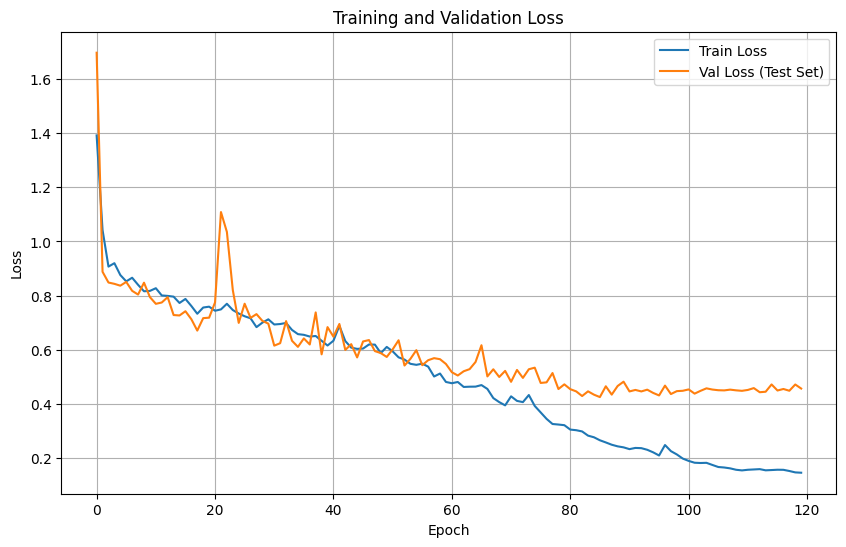

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss (Test Set)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

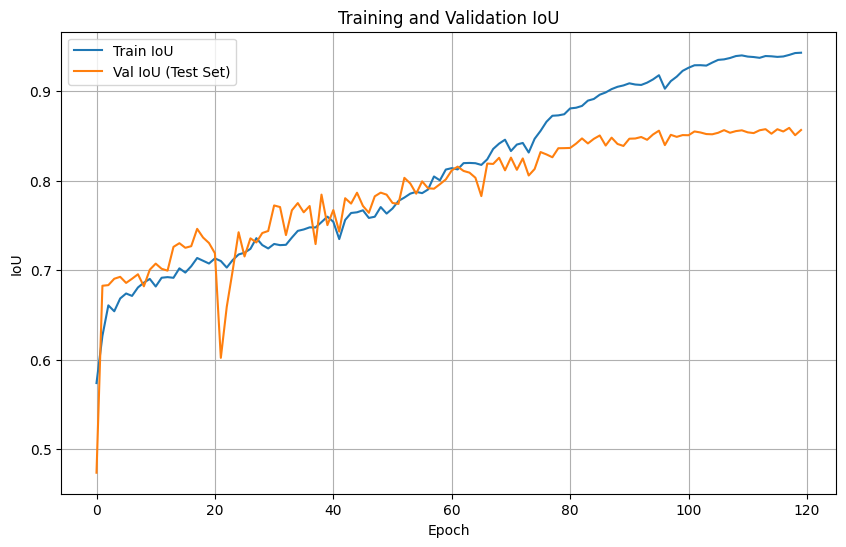

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU (Test Set)')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation Metrics

In [ ]:
import segmentation_models_pytorch as smp

def evaluate_model(model, loader, device, threshold=0.5):
    model.eval()
    iou_total = 0.0
    precision_total = 0.0
    recall_total = 0.0
    f1_total = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).float().squeeze(-1).unsqueeze(1)  # ✅ same as training loop

            outputs = model(images)             # logits
            probs = torch.sigmoid(outputs)      # probabilities

            # --- SMP metrics ---
            tp, fp, fn, tn = smp.metrics.get_stats(
                probs, masks.long(),
                mode="binary", threshold=threshold
            )

            # IoU
            iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            # Precision, Recall, F1
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
            recall    = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
            f1        = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

            iou_total       += iou.item()
            precision_total += precision.item()
            recall_total    += recall.item()
            f1_total        += f1.item()
            num_batches     += 1

    return {
        'IoU':       iou_total / num_batches,
        'Precision': precision_total / num_batches,
        'Recall':    recall_total / num_batches,
        'F1':        f1_total / num_batches
    }

In [ ]:
metrics = evaluate_model(nn_model, test_loader, device)
print(metrics)

{'IoU': 0.8565531671047211, 'Precision': 0.9350288212299347, 'Recall': 0.9105217158794403, 'F1': 0.9225998222827911}


In [ ]:
import torchmetrics

def evaluate_model_torchmetrics(model, loader, device, threshold=0.5):
    model.eval()

    # Torchmetrics metrics
    jaccard = torchmetrics.JaccardIndex(task="binary").to(device)
    precision = torchmetrics.Precision(task="binary").to(device)
    recall = torchmetrics.Recall(task="binary").to(device)
    f1 = torchmetrics.F1Score(task="binary").to(device)

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).float().squeeze(-1).unsqueeze(1)  # ✅ match training loop

            outputs = model(images)             # logits
            probs = torch.sigmoid(outputs)      # probabilities
            preds = (probs > threshold).long()  # binary mask

            # Update torchmetrics
            jaccard.update(preds, masks.long())
            precision.update(preds, masks.long())
            recall.update(preds, masks.long())
            f1.update(preds, masks.long())

    return {
        "IoU (torchmetrics)": jaccard.compute().item(),
        "Precision": precision.compute().item(),
        "Recall": recall.compute().item(),
        "F1": f1.compute().item(),
    }

In [ ]:
torchMetrics = evaluate_model_torchmetrics(nn_model, test_loader, device)
print(torchMetrics)

{'IoU (torchmetrics)': 0.8567724227905273, 'Precision': 0.9353118538856506, 'Recall': 0.9107393622398376, 'F1': 0.9228620529174805}


## Visualize Predictions

In [ ]:
import random

def visualize_prediction_rgb_samples(model, test_pairs, mins, maxs, device, n_samples=1, use_indices=True):
    selected_pairs = random.sample(test_pairs, min(n_samples, len(test_pairs)))
    for img_path, mask_path in selected_pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        if use_indices:
            img = compute_water_indices(img)
        mask = load_mask(mask_path)
        # Create RGB image from bands (Red: 3, Green: 2, Blue: 1)
        rgb_img = img[[3, 2, 1]]  # Select Red, Green, Blue bands
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-6)  # Normalize for display
        img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            pred = model(img_tensor).squeeze().cpu().numpy() > 0.5
        fig, axs = plt.subplots(1, 3, figsize=(12, 5))
        axs[0].imshow(np.transpose(rgb_img, (1, 2, 0)))  # Transpose to (H, W, C) for imshow
        axs[0].set_title('RGB Image')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[2].imshow(pred, cmap='gray')
        axs[2].set_title('Predicted Mask')
        plt.show()

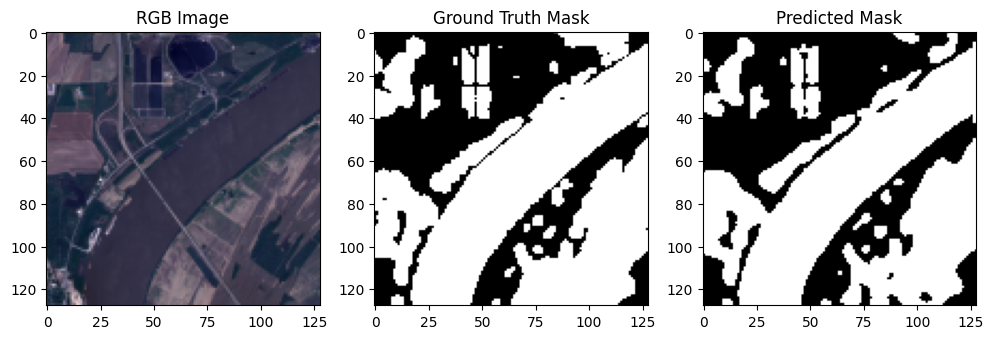

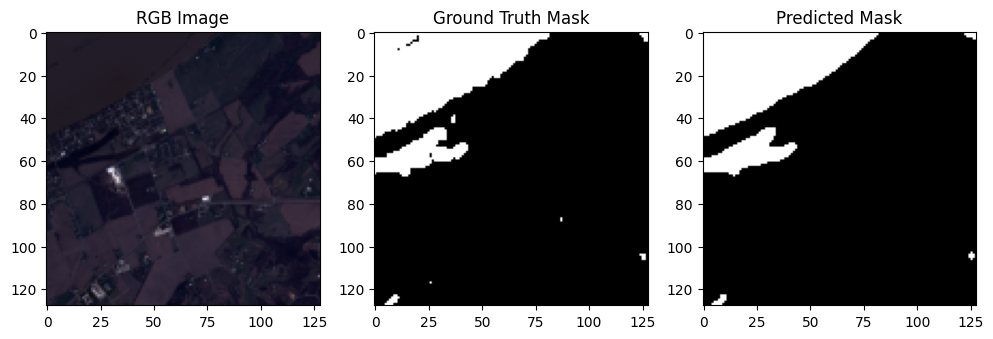

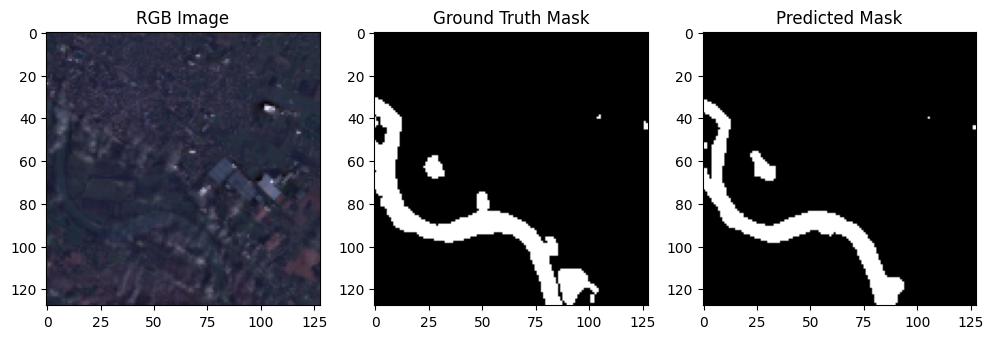

In [ ]:
# Call the visualize_prediction_rgb_samples function
visualize_prediction_rgb_samples(nn_model, test_pairs, mins, maxs, device, n_samples=3)

In [ ]:
import random
import matplotlib.colors as mcolors

def visualize_prediction_rgb_samples(model, test_image_paths, test_mask_paths, mins, maxs, device, n_samples=1, use_indices=True):
    selected_indices = random.sample(range(len(test_image_paths)), min(n_samples, len(test_image_paths)))

    # Create a colormap for masks: 0 (no water) as black, 1 (water) as blue
    cmap_mask = mcolors.ListedColormap(['black', 'blue'])
    bounds = [0, 0.5, 1]
    norm_mask = mcolors.BoundaryNorm(bounds, cmap_mask.N)

    for idx in selected_indices:
        img_path = test_image_paths[idx]
        mask_path = test_mask_paths[idx]

        # Load, normalize, and potentially add indices to the image
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        if use_indices:
            img = compute_water_indices(img)

        # Load the mask
        mask = load_mask(mask_path)

        # Create RGB image from bands (Red: 3, Green: 2, Blue: 1)
        # Ensure bands exist before selecting
        if img.shape[0] > 3: # Check if there are at least 4 bands (0-indexed 3 is the 4th band)
             rgb_img = img[[3, 2, 1], :, :]  # Select Red, Green, Blue bands
             # Normalize for display
             rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-6)
             rgb_img_display = np.transpose(rgb_img, (1, 2, 0)) # Transpose to (H, W, C) for imshow
        else:
             # If not enough bands for RGB, just show the first band or handle differently
             print(f"Warning: Not enough bands ({img.shape[0]}) to create RGB image for sample {idx}. Showing first band.")
             rgb_img_display = img[0, :, :] # Show first band

        # Prepare image tensor for model prediction
        img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)

        # Get model prediction
        model.eval()
        with torch.no_grad():
            pred = model(img_tensor).squeeze().cpu().numpy() > 0.5

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot Input Image (RGB approximation or first band)
        if rgb_img_display.ndim == 3:
            axs[0].imshow(rgb_img_display)
            axs[0].set_title('RGB Image')
        else:
             axs[0].imshow(rgb_img_display, cmap='gray')
             axs[0].set_title('Input Image (Band 1)')

        axs[0].axis('off')


        # Plot Ground Truth Mask with custom colormap
        axs[1].imshow(mask, cmap=cmap_mask, norm=norm_mask)
        axs[1].set_title('Ground Truth Mask (Blue: Water)')
        axs[1].axis('off')

        # Plot Predicted Mask with custom colormap
        axs[2].imshow(pred, cmap=cmap_mask, norm=norm_mask)
        axs[2].set_title('Predicted Mask (Blue: Water)')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

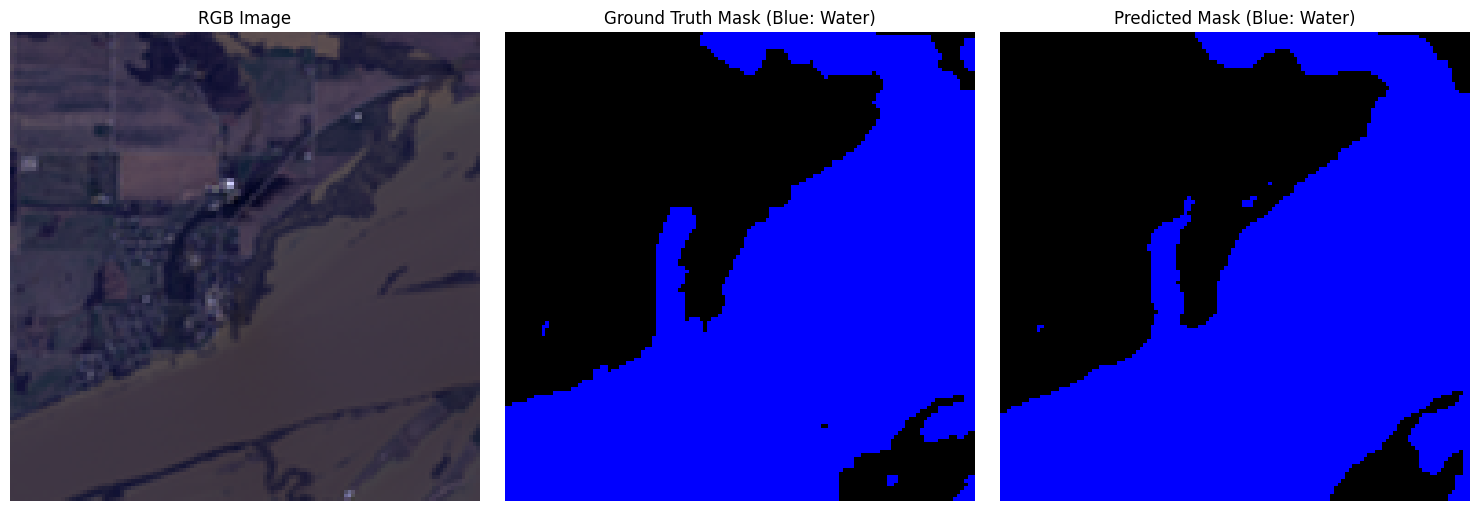

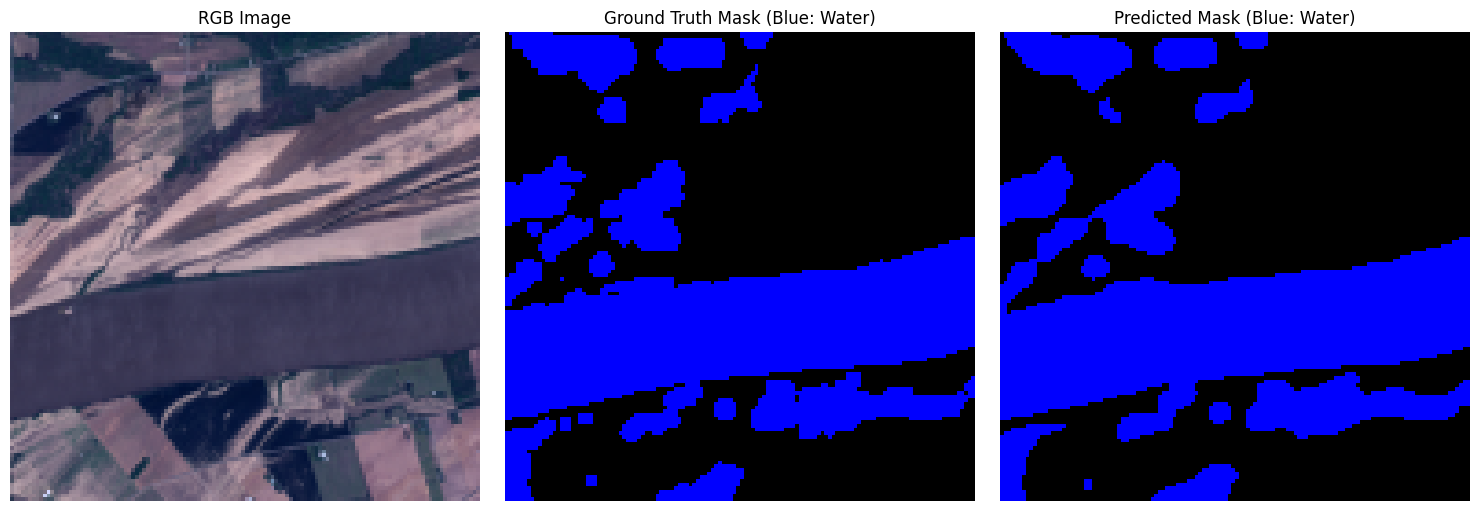

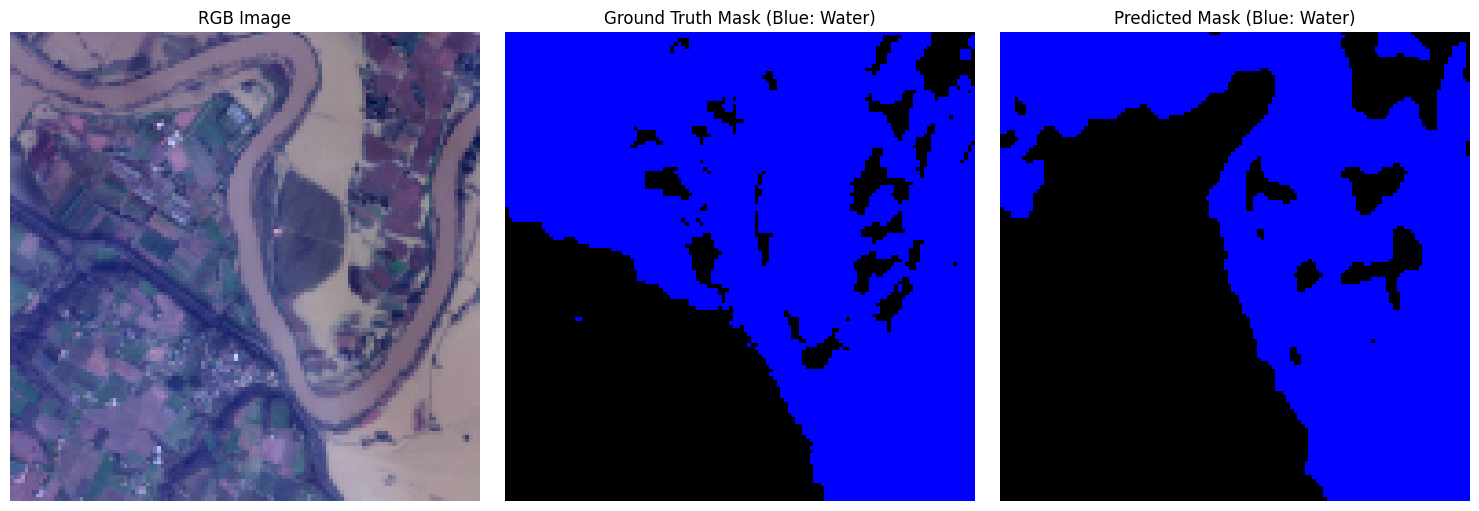

In [ ]:
# Example: Visualize 3 random test samples
test_image_paths = [pair[0] for pair in test_pairs]
test_mask_paths = [pair[1] for pair in test_pairs]
visualize_prediction_rgb_samples(nn_model, test_image_paths, test_mask_paths, mins, maxs, device, n_samples=3)



---

# Deployment using Streamlit and Ngrok

In [ ]:
# 1) install dependencies
!pip install -q streamlit pyngrok

In [ ]:
## for using the token without showing it, delete after running it
# import os
# os.environ["NGROK_AUTH_TOKEN"] = "your-token-here"

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token(os.environ["NGROK_AUTH_TOKEN"])

In [ ]:
%%writefile app.py

import streamlit as st
from pyngrok import ngrok
from pathlib import Path
import torch
import numpy as np
import rasterio
import cv2
import os
import shutil


# Change caption color to black
st.markdown(
    """
    <style>
    .stImage caption {
        color: black !important;
        font-weight: 500;
    }
    </style>
    """,
    unsafe_allow_html=True
)


# Assume the model is saved as 'best_model_iou.pth'
# best_model_path_iou = 'best_model_iou.pth'  # File to save the best model
best_model_path_val_loss = 'best_model_val_loss.pth'
# Define paths for saved mins and maxs
mins_path = 'mins.npy'
maxs_path = 'maxs.npy'


# --- Define necessary functions (copying from your notebook) ---

# Function to Load Multispectral Image (assuming you want to use the 12 bands + indices)
def load_image_for_inference(path):
    with rasterio.open(path) as src:
        img = src.read()  # Shape: (bands, height, width)
        img = img.astype(np.float32)
    return img


# Function to Normalize Image (Min-Max Scaling)
def normalize_image_for_inference(img, mins, maxs):
    # Ensure the image has the same number of channels as mins/maxs
    if img.shape[0] != len(mins):
        st.error(f"Image has {img.shape[0]} bands, but mins/maxs have {len(mins)}. Normalization failed.")
        return img # Or raise an error

    normalized_img = np.copy(img) # Avoid modifying the original img array
    for c in range(len(mins)):
         # Handle cases where max-min is zero
        denominator = (maxs[c] - mins[c])
        if denominator == 0:
             normalized_img[c] = 0 # or handle as appropriate, maybe leave as is?
        else:
             normalized_img[c] = (img[c] - mins[c]) / (denominator + 1e-6)
    return normalized_img


# Function to Compute Water Indices
def compute_water_indices_for_inference(img):
    # Channel indices based on diagram: 0: Coastal, 1: Blue, 2: Green, 3: Red, 4: NIR, 5: SWIR1, 6: SWIR2, ...
    blue = img[1]
    green = img[2]
    red = img[3]
    nir = img[4]
    swir1 = img[5]
    swir2 = img[6]

    ndwi = (green - nir) / (green + nir + 1e-10)
    mndwi = (green - swir1) / (green + swir1 + 1e-10)
    awei_sh = 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)
    ## New:
    awei_ns = blue + 2.5 * green - 1.5 * (nir + swir1) - 0.25 * swir2
    ndvi = (nir - red) / (nir + red + 1e-10)

    indices = np.stack([ndwi, mndwi, awei_sh, awei_ns, ndvi], axis=0)
    img_with_indices = np.concatenate([img, indices], axis=0)  # Now (17, 128, 128)

    return img_with_indices

# Function to Perform Inference
def inference_on_tif(model, tif_path, mins, maxs, device, img_size=128, include_indices=True):
    img = load_image_for_inference(tif_path)

    # Handle potential resizing if image is not img_size x img_size
    if img.shape[1] != img_size or img.shape[2] != img_size:
        st.warning(f"Image size is {img.shape[1]}x{img.shape[2]}. Resizing to {img_size}x{img_size}.")
        # Assuming channel-first (C, H, W)
        resized_img = np.zeros((img.shape[0], img_size, img_size), dtype=img.dtype)
        for c in range(img.shape[0]):
             resized_img[c, :, :] = cv2.resize(img[c, :, :], (img_size, img_size), interpolation=cv2.INTER_AREA)
        img = resized_img

    # Normalize the image using the loaded mins/maxs
    img = normalize_image_for_inference(img, mins, maxs)

    # Compute water indices if required
    if include_indices:
        img = compute_water_indices_for_inference(img)

    # Ensure the image has the correct number of channels for the model
    expected_channels = model_in_channels
    if img.shape[0] != expected_channels:
         st.error(f"Processed image has {img.shape[0]} channels, but model expects {expected_channels}. Cannot run inference.")
         return None # Indicate failure

    # Prepare image tensor
    img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)

    # Perform inference
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)

    # Post-process output
    probs = torch.sigmoid(output)
    pred_mask = (probs.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    return pred_mask


import segmentation_models_pytorch as smp

def get_model_resnet34(num_channels, classes=1):
    model = smp.Unet(
        encoder_name="resnet34",           # pretrained backbone
        encoder_weights="imagenet",        # load ImageNet weights, pretrained on 3-ch, first conv adapted to 17
        in_channels=num_channels,          # 17 spectral bands
        classes=classes,                   # binary segmentation
        # activation="sigmoid"               # last layer activation function
        decoder_use_norm=True,                # defaults to BatchNormalization
        activation=None                    # outputs raw logits
    )

    # fix conv1 mapping (### this is to encode weights of 'image_net' to the actual rgb channels as they were supposed to)
    conv1 = model.encoder.conv1  # shape (64, 17, 7, 7) (number of output filters, input_channels, kernel_height, kernel_width)

    # Dataset channel positions for RGB, in the 17-channel input
    red_idx, green_idx, blue_idx = 3, 2, 1

    with torch.no_grad():
        # Copy pretrained ImageNet weights to the correct channels
        conv1.weight[:, red_idx]   = conv1.weight[:, 0].clone() # copy pretrained R → dataset's Red
        conv1.weight[:, green_idx] = conv1.weight[:, 1].clone() # pretrained G → dataset's Green
        conv1.weight[:, blue_idx]  = conv1.weight[:, 2].clone() # pretrained B → dataset's Blue

        # Reset the first 3 slots so they don’t overlap
        nn.init.kaiming_normal_(conv1.weight[:, 0:3])

    return model


# --- Load the model and mins/maxs ---
# Ensure the model architecture matches the saved state_dict
# You need the same num_channels used during training (17 if indices were used)

model_in_channels = 17

try:
    try:
        # Attempt to use get_model from the notebook environment
        model = get_model_resnet34(num_channels=model_in_channels)
    except NameError:
        st.error("The 'get_model' function is not defined. Please ensure the cell defining 'get_model' has been run, or define it within app.py.")
        st.stop()


    model.load_state_dict(torch.load(best_model_path_val_loss, map_location='cpu'))
    model.eval()
    st.success(f"Model loaded successfully from {best_model_path_val_loss}")

    # Load mins and maxs
    mins = np.load(mins_path)
    maxs = np.load(maxs_path)
    st.success("Mins and maxs loaded successfully.")

except FileNotFoundError as e:
    st.error(f"Required file not found: {e}. Please ensure {best_model_path_val_loss}, {mins_path}, and {maxs_path} exist.")
    st.stop()
except Exception as e:
    st.error(f"Error during setup: {e}")
    st.stop()


# --- Streamlit App ---
st.title("Satellite Image Water Segmentation")

uploaded_file = st.file_uploader("Upload a multispectral .tif image", type=['tif', 'tiff'])

if uploaded_file is not None:
    # Save the uploaded file temporarily
    temp_dir = "temp_uploads"
    os.makedirs(temp_dir, exist_ok=True)
    temp_path = os.path.join(temp_dir, uploaded_file.name)
    with open(temp_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    st.write("Processing image...")

    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Perform inference
    # Pass the loaded mins and maxs to the inference function
    predicted_mask = inference_on_tif(model, temp_path, mins, maxs, device, img_size=128, include_indices=True)

    if predicted_mask is not None:
        st.write("Inference complete.")

        # Display Original RGB (Approximation)
        try:
             # Load the original 12-band image again just for RGB display
            original_img_12_bands = load_image_for_inference(temp_path)
            # Normalize for display (using the notebook mins/maxs if available, or global min/max of RGB bands)
            # Simple global min/max for display purposes of RGB
            if original_img_12_bands.shape[0] > 3:
                rgb_display_bands = original_img_12_bands[[3, 2, 1], :, :] # Red, Green, Blue bands
                # Normalize for display
                rgb_display_bands = (rgb_display_bands - rgb_display_bands.min()) / (rgb_display_bands.max() - rgb_display_bands.min() + 1e-6)
                rgb_display = np.transpose(rgb_display_bands, (1, 2, 0))
                st.subheader("Original Image (RGB Approximation)")
                # st.image(rgb_display, caption="RGB Image", use_container_width=True)
                st.image(rgb_display, caption="RGB Image", width=400)
            else:
                 st.warning("Could not create RGB approximation (less than 4 bands in original image).")

        except Exception as e:
             st.warning(f"Could not display RGB approximation: {e}")


        # Display Predicted Mask (make it blue for water)
        st.subheader("Predicted Water Mask")
        # Create a simple blue mask visualization
        # Water pixels (1) will be blue, non-water (0) will be black
        colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8) # H, W, C (RGB)
        colored_mask[predicted_mask == 1] = [0, 0, 255] # Blue color for water

        # st.image(colored_mask, caption="Predicted Water Mask (Blue)", use_container_width=True)
        st.image(colored_mask, caption="Predicted Water Mask (Blue)", width=400)  # adjust width as needed


    # If you want both images in one row (RGB + Mask), use Streamlit columns:
    st.subheader("Results Side by Side:")

    col1, col2 = st.columns(2)
    with col1:
        st.image(rgb_display, caption="RGB Image", width=350)
    with col2:
        st.image(colored_mask, caption="Predicted Water Mask (Blue)", width=350)


    # Clean up the temporary file
    os.remove(temp_path)
    os.rmdir(temp_dir)

    # to make sure it deletes temp files
    shutil.rmtree(temp_dir, ignore_errors=True)

# --- Ngrok Tunnel (Optional for public access) ---
# You only need to run the ngrok part if you want to expose your app publicly.
# For running locally in Colab, the local Streamlit URL is often sufficient.
# To use ngrok, you need to install it (`!pip install pyngrok`) and potentially set an auth token.

# Check if ngrok is already running or connect
try:
    public_url = ngrok.connect(8501)
    st.write("Ngrok Tunnel:")
    st.write(public_url)
except Exception as e:
    st.warning(f"Could not establish Ngrok tunnel: {e}. Streamlit app might only be accessible locally.")
    st.info("To use Ngrok, you might need to install it (`!pip install pyngrok`) and potentially set an auth token (`ngrok.set_auth_token('YOUR_AUTH_TOKEN')`).")

# --- Instructions to run Streamlit ---
st.sidebar.markdown("## How to Run")
st.sidebar.markdown("1. Upload an Image by selecting Browse Files.")
st.sidebar.markdown("2. the multispectral image you uploaded will be shown in RGB Format.")
st.sidebar.markdown("3. The model will visualize a water mask segmenting the water body in the photo you uploaded.")
# If using ngrok, the public URL will also be printed.

In [ ]:
import os, time
from pyngrok import ngrok
from IPython.display import display, HTML

APP_PATH = "app.py"
PORT = 8501

# Run streamlit headless in background
streamlit_cmd = f"streamlit run {APP_PATH} --server.port {PORT} --server.headless true &"
print("Starting Streamlit with:", streamlit_cmd)
os.system(streamlit_cmd)

# Wait for boot
time.sleep(3)

# Create Ngrok tunnel
public_tunnel = ngrok.connect(PORT, bind_tls=True)
print("ngrok tunnel created:", public_tunnel.public_url)

# Clickable link
display(HTML(f'<a href="{public_tunnel.public_url}" target="_blank">Open Streamlit app (ngrok)</a>'))

## To Close the site

In [ ]:
from pyngrok import ngrok

# Kill all ngrok tunnels
ngrok.kill()

#